<a href="https://colab.research.google.com/github/giriragav/UChicago---QCSD/blob/main/Module%203/lab6/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before you turn this lab in, make sure everything runs as expected. **Restart and run all cells** (in the menubar, select Kernel$\rightarrow$Restart & Run All) then check the output is as expected and there are no errors.  Also remember to **Save** before uploading this file (File$\rightarrow$Save and Checkpoint).

---

# <div align="center">Quantum Computer Systems Design</div>&nbsp;  <div align="center">Lab 6</div>

In the videos, we looked at three key compilation passes to transform input passes to executable programs on quantum hardware: mapping, scheduling, and routing. For this lab, we will assume all 1 and 2 qubit gates are executable on hardware, i.e. there is no need to resynthesize etc. In this lab, you will implement a simple pass to accomplish each of these tasks. This will most likely take longer than previous labs, so start early.

In part 1 you will implement a mapper: given a target hardware connectivity graph and an input program, map the qubits to the hardware in an efficient way (i.e. qubits which interact frequently should be mapped closely together). In part 2 you will implement a simple router: given a mapped program and the program route operations in an efficient way (use as few SWAPs as possible to shift qubits around the device); here we will assume a move there, execute 2 qubit gate, move back strategy. In part 3 you will schedule your gates to minimize the total execution time of the program: given execution times for each of the gates, assign start times to each gate to minimize total execution time.


Grading: There are a lot of optimizations which can be made in each of these functions. The grading for this assignment will be 2-fold. Passes which output correct circuits without too much overhead will receive full credit (e.g. don't write very naive solutions which add too many swaps or schedule 2x as long as needed).


# 0.1. Programs For Development

Below is the same code from last lab which generates the Cuccarro Adder. You're welcome to use this circuit, which has been decomposed into 1 and 2 qubit gates, or any other as you develop your compilation passes. You can adjust the size of the below program `qiskit.transpile(generate_adder_circuit(4), basis_gates=['cx', 'rx', 'h', 'rz'])` by changing the `4` to some other even number for larger circuits. We suggest testing on small circuits however. Even simpler circuits containing only a small number of CNOTs may be beneficial. The grader tests might use programs you have not seen before.

In [1]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import networkx as nx
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Qubit
from IPython.display import display

from typing import Dict, Any, List

In [3]:
# A test program for you to use during development.

# Implementation of the Cuccaro Quantum Adder from
#   https://github.com/jmbaker94/quantumcircuitbenchmarks
# Design from the paper
#   https://arxiv.org/abs/quant-ph/0410184

# Majority gate
maj_c = QuantumCircuit(3, name='MAJ')
maj_c.cx(2, 1)
maj_c.cx(2, 0)
maj_c.ccx(0, 1, 2)
maj = maj_c.to_gate(label='MAJ')
print("MAJ Circuit:")
display(maj_c.draw(fold=-1))

# 2-CNOT version of UnMajority and Add gate
uma2_c = QuantumCircuit(3, name='UMA2')
uma2_c.ccx(0, 1, 2)
uma2_c.cx(2, 0)
uma2_c.cx(0, 1)
uma2 = uma2_c.to_gate(label='UMA2')
print("uma2 Circuit:")
display(uma2_c.draw(fold=-1))

# 3-CNOT version of UnMajority and Add gate
# (Allows more parallelism in the circuit)
uma3_c = QuantumCircuit(3, name='UMA3')
uma3_c.x(1)
uma3_c.cx(0, 1)
uma3_c.ccx(0, 1, 2)
uma3_c.x(1)
uma3_c.cx(2, 0)
uma3_c.cx(2, 1)
uma3 = uma3_c.to_gate(label='UMA3')
print("uma3 Circuit:")
display(uma3_c.draw(fold=-1))


def cuccaro_adder(c, cin, a, b, cout, uma=uma3):
    c.append(maj, [cin, b[0], a[0]])
    for i in range(1, len(b)):
        c.append(maj, [a[i-1], b[i], a[i]])

    c.cx(a[-1], cout)

    for i in reversed(range(1, len(b))):
        c.append(uma, [a[i-1], b[i], a[i]])
    c.append(uma, [cin, b[0], a[0]])

def generate_adder_circuit(n, uma=uma3):
    if n % 2 != 0:
        raise ValueError('Odd number of qubits')

    qubits = QuantumRegister
    cin = range(1)
    a = range(1, n//2)
    b = range(n//2, n-1)
    cout = range(n-1, n)
    c = QuantumCircuit(n)

    cuccaro_adder(c, cin, a, b, cout, uma=uma)
    return c

def decomposed_adder_circuit(n):
    return qiskit.transpile(generate_adder_circuit(n),
                            basis_gates=['cx', 'rx', 'h', 'rz'])

print('Cuccaro Adder:')
display(generate_adder_circuit(4).draw(fold=-1))
cuccaro = decomposed_adder_circuit(4)
cuccaro.draw(fold=-1)

MAJ Circuit:


┌───┐     
q_0: ─────┤ X ├──■──
     ┌───┐└─┬─┘  │  
q_1: ┤ X ├──┼────■──
     └─┬─┘  │  ┌─┴─┐
q_2: ──■────■──┤ X ├
               └───┘

uma2 Circuit:


┌───┐     
q_0: ──■──┤ X ├──■──
       │  └─┬─┘┌─┴─┐
q_1: ──■────┼──┤ X ├
     ┌─┴─┐  │  └───┘
q_2: ┤ X ├──■───────
     └───┘

uma3 Circuit:


┌───┐     
q_0: ───────■────■───────┤ X ├─────
     ┌───┐┌─┴─┐  │  ┌───┐└─┬─┘┌───┐
q_1: ┤ X ├┤ X ├──■──┤ X ├──┼──┤ X ├
     └───┘└───┘┌─┴─┐└───┘  │  └─┬─┘
q_2: ──────────┤ X ├───────■────■──
               └───┘

Cuccaro Adder:


┌──────┐     ┌───────┐
q_0: ┤0     ├─────┤0      ├
     │      │     │       │
q_1: ┤2 MAJ ├──■──┤2 UMA3 ├
     │      │  │  │       │
q_2: ┤1     ├──┼──┤1      ├
     └──────┘┌─┴─┐└───────┘
q_3: ────────┤ X ├─────────
             └───┘

global phase: 5π/4
          ┌───┐                                                                            ┌─────────┐                                                                                                              ┌───┐       
q_0: ─────┤ X ├────────────────────────■────────────────────────────────■───────────────■──┤ Rz(π/2) ├───────────────────────────────────────■────────────────────────────────■───────────────■────────────────■────┤ X ├───────
          └─┬─┘┌───┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  └──┬───┬──┘               ┌───┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │     ┌───┐      │    └─┬─┘       
q_1: ──■────■──┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├───────────────■──┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├──────┼──────■──────■──
     ┌─┴─┐     └───┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────┘┌─┴─┐┌──┴───┴───┐┌───────┐  │  └───┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────┘┌─┴─┐┌──┴───┴───┐┌─┴─┐┌───────┐┌─┴─┐
q_2: ┤ X ├────────────■────────────────────────────────■──┤ Rz(π/4) ├─────────────────┤ X ├┤ Rz(-π/4) ├┤ Rx(π) ├──┼─────────■────────────────────────────────■──┤ Rz(π/4) ├─────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rx(π) ├┤ X ├
     └───┘                                                └─────────┘                 └───┘└──────────┘└───────┘┌─┴─┐                                           └─────────┘                 └───┘└──────────┘└───┘└───────┘└───┘
q_3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                └───┘

# 0.2. Data Structures and Iterating through Qiskit Programs

Before you get started, let's build some basic data structures you may need for your passes. These objects are for your use, but you do not have to use them in your implementation of the below passes. You may want to modify the data structures to account for other parameters, such as gate times. It may be helpful to read through these functions to see how to manipulate `qiskit.QuantumCircuit`.

In [4]:
# 0.2.0 Wrapping Gates to Make them hashable in a graph structure and give them a unique identifying label
import dataclasses
@dataclasses.dataclass
class GateWrapper:
    gate:Any
    qubits:List[Qubit]
    extra_params:List[Any]
    label:str

    def __hash__(self):
        return hash((type(self.gate), tuple(self.qubits), self.label))

    def __str__(self):
        args = ','.join(str(q._index) for q in self.qubits)
        return f'{self.label}{{{self.gate.name}({args})}}'

    def __repr__(self):
        return str(self)

# 0.2.1 Building a new circuit from an old circuit (This is just to see how to use gates from old circuits)
def copy_a_circuit(old_circuit, n):
    '''
    QuantumCircuit's operate on registers of qubits. If the number of qubits in old_circuit is different from the number of qubits in the new circuit
    you need to convert the qubits from old to new.

    This function explains how to copy gates from one set of qubits to another in a different circuit.

    Args:
        old_circuit: the circuit to copy
        n: number of qubits in the new circuit

    '''
    new_circuit = qiskit.QuantumCircuit(n)

    for instr in old_circuit:
        # If n = number of qubits in old_circuit this is O.K.
        # new_circuit.append(instr)

        # If n != number of qubits in old_circuit the above is NOT O.K.
        # Instead, convert the indices
        # DO NOT use both this and the above.
        new_qubit_indices = [instr.qubits[i]._index for i in range(len(instr.qubits))]
        new_circuit.append(instr.operation, new_qubit_indices, instr.clbits)

    return new_circuit

# 0.2.2 Building a Dependency Graph using NetworkX
def build_program_dependency_graph(circuit):
    '''
    Builds a program dependency graph like in the video. Feel free to modify this or build your own as you see fit.
    Here we convert the gates into their hashable versions and add a label.
    '''

    # Starting Label Index
    i = 0

    # A dictionary to store the last use of any qubit
    qubit_last_use = {}

    g = nx.DiGraph()

    # Add the start node
    g.add_node(-1)

    for instr in circuit:

        hashable_gate = GateWrapper(instr.operation, instr.qubits, instr.clbits, label=i)
        i += 1

        g.add_node(hashable_gate)

        # Add edges based on qubit_last_use; update last use
        for qubit in hashable_gate.qubits:
            if qubit in qubit_last_use:
                g.add_edge(qubit_last_use[qubit], hashable_gate)
            else:
                g.add_edge(-1, hashable_gate)

            qubit_last_use[qubit] = hashable_gate

    # Add the end node
    g.add_node(float('inf'))

    for qubit in qubit_last_use:
        g.add_edge(qubit_last_use[qubit], float('inf'))

    return g

# 0.2.3 From Dependency Graph with Hashable Gates to Qiskit Gates
def dependency_graph_to_circuit(dep_graph, n):
    '''
    Takes a dependency graph and the number of qubits n
    '''

    circuit = qiskit.QuantumCircuit(n)

    for gate in nx.topological_sort(dep_graph):

        if gate not in [-1, float('inf')]:
            circuit.append(gate.gate, gate.qubits, gate.extra_params)

    return circuit

# 0.2.4 Interaction Graphs
def interaction_graph_from_circuit(circuit):
    '''
    Builds a weighted interaction graph for a given circuit.

    Nodes are qubits
    Edges are weighted by the number of times pairs of qubits interact
    '''
    g = nx.Graph()

    for instr in circuit:
        for q in instr.qubits:
            g.add_node(q)

        for i in range(len(instr.qubits)):
            for j in range(i):
                q1 = instr.qubits[i]
                q2 = instr.qubits[j]
                if q1 != q2:
                    if (q1, q2) not in g.edges:
                        g.add_edge(q1, q2, weight=1)
                    else:
                        g.edges[q1, q2]['weight'] += 1

    return g

# 0.2.5 Checking if a gate is a certain type
basic_c = QuantumCircuit(1)
basic_c.rz(np.pi / 2, 0)
basic_c.h(0)
basic_c.x(0)

for instr in basic_c:
    if isinstance(instr.operation, qiskit.circuit.library.standard_gates.rz.RZGate):
        print("This is an RZ gate")
    if isinstance(instr.operation, qiskit.circuit.library.standard_gates.HGate):
        print("This is a H gate")
    if isinstance(instr.operation, qiskit.circuit.library.standard_gates.XGate):
        print("This is a X gate")

This is an RZ gate
This is a H gate
This is a X gate


In [5]:
# Helper functions to visualize
def draw_interaction_graph(ig):
    nx.draw(nx.relabel_nodes(ig, {q: f'{q._register.name}_{q._index}' for q in ig.nodes}),
            with_labels=True)

def draw_dependency_graph(dep_g):
    nx.draw(dep_g, with_labels=True)

def draw_hardware_graph(target_hardware):
    nx.draw(target_hardware, with_labels=True)

def draw_mapping(target_hardware, mapping):
    rev_mapping = {hw_q: None for hw_q in target_hardware.nodes}
    for k, v in mapping.items():
        assert v in rev_mapping, (
            'Invalid mapping: cannot map a circuit qubit to a non-existant hardware qubit '
            f'({k}->{v} but {v} does not exist)')
        assert rev_mapping[v] is None, (
            'Invalid mapping: cannot map two circuit qubits to the same qubit on hardware '
            f'({rev_mapping[v]}->{v} and {k}->{v})')
        rev_mapping[v] = k
    nx.draw(nx.relabel_nodes(target_hardware,
                             {hw_q: f'''q{getattr(rev_mapping[hw_q], '_index', None)
                                         }->{hw_q}'''
                              for hw_q in target_hardware.nodes}),
            with_labels=True)

def draw_routing(routed_circuit):
    routed_circuit.draw(fold=-1)

┌───┐
q_0: ──────────┤ X ├
          ┌───┐└─┬─┘
q_1: ─────┤ X ├──┼──
     ┌───┐└─┬─┘  │  
q_2: ┤ X ├──■────■──
     └───┘

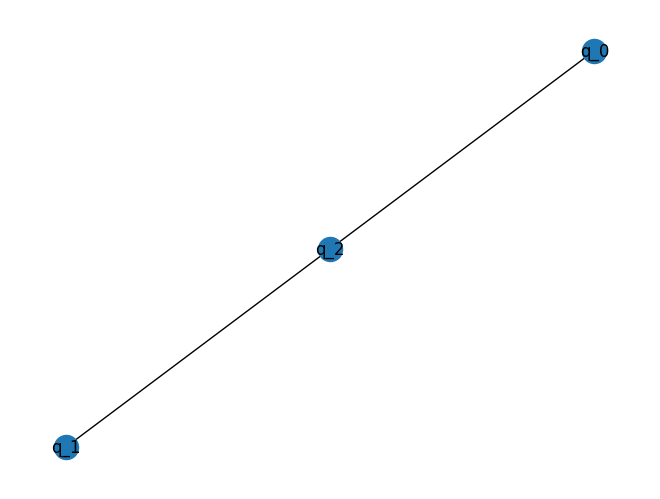

In [6]:
simple = QuantumCircuit(3)
# simple.cx(0, 1)
# simple.cx(1, 0)
simple.x(2)
simple.cx(2,1)
simple.cx(2,0)
display(simple.draw(fold=-1))

ig = interaction_graph_from_circuit(simple)
dep_g = build_program_dependency_graph(simple)
draw_interaction_graph(ig)

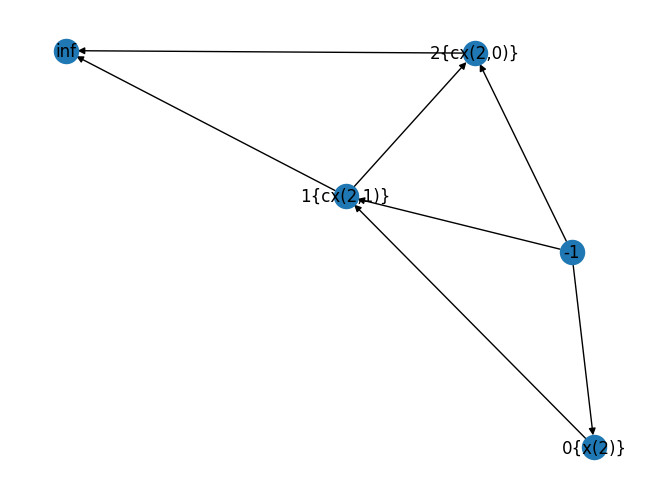

In [7]:
draw_dependency_graph(dep_g)

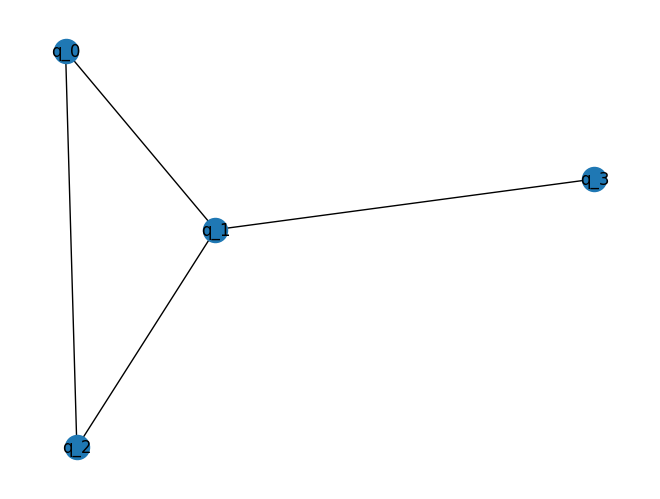

In [8]:
draw_interaction_graph(interaction_graph_from_circuit(cuccaro))

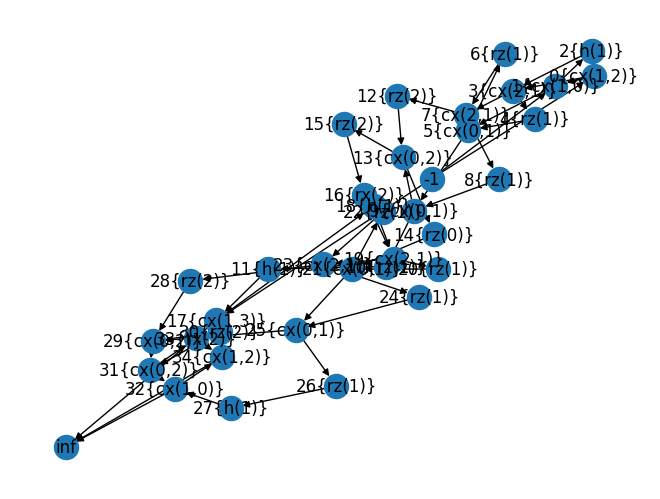

In [9]:
draw_dependency_graph(build_program_dependency_graph(cuccaro))

# 1. Mapping Programs to Hardware

Your first task is to map program qubits to hardware qubits in a good way - here this means you want to make sure qubits which interact frequently (given by the weights
of edges in the interaction graph) are mapped close together. Your mapper should try to minimize, using a heursitic, the total distance between interacting qubits. How you do the mapping is up to you. Good mappings usually lead to good routing.

Metric to minimize:
    $$
        \sum_{u \in Q}\sum_{v \in Q} w(u, v) * d(u, v)
    $$
Where $Q$ is the set of qubits, $w(u, v)$ is the number of times $u, v$ interact in the program (check the interaction graph edge weights) and $d(u, v)$ is the shortest path distance between $u$ and $v$ once they've been mapped. $w(u, v) = 0$ if there is no edge between $u$ and $v$ in the interaction graph.

Hints:
- You may need some of the objects [`nx.Graph`](https://networkx.org/documentation/stable/reference/classes/graph.html), [`nx.DiGraph`](https://networkx.org/documentation/stable/reference/classes/digraph.html), and functions [`nx.all_pairs_shortest_path_length`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.unweighted.all_pairs_shortest_path_length.html), [`all_pairs_shortest_path`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.unweighted.all_pairs_shortest_path.html) for this problem set.
- Iterate over graph nodes with `for node in graph.nodes:`
- Iterate over graph edges with `for node1, node2 in graph.edges:`
- Get the 'weight' of an interaction graph edge (the number of CNOTs between those two qubits) with `ig[q1][q2]['weight']`.

Make sure your code runs quickly.  Each test shouldn't run longer than a second and 30 seconds will timeout the grader.

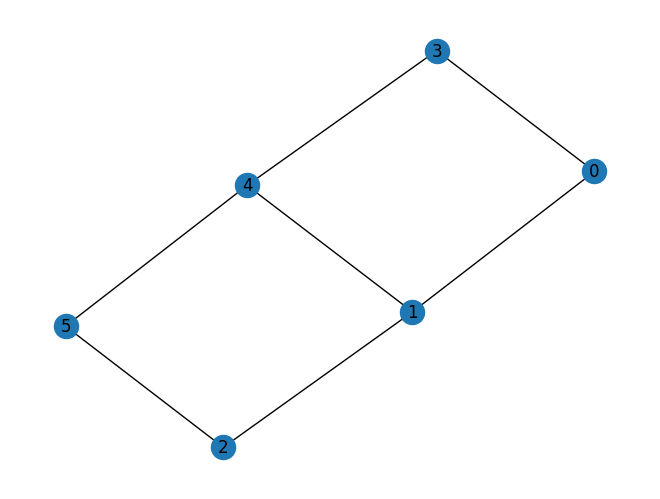

In [10]:
# Here is some sample hardware. Feel free to change this for your testing.
# This is hardware with a simple linear connectivity 0 - 1 - 2 - ... - n-1
# Graphs with nodes numbered 0, 1, ..., n-1:
simple_hardware = nx.path_graph(5)
# This is hardware with a simple 2x3 grid connectivity
grid_hardware = nx.grid_2d_graph(2, 3)
grid_hardware = nx.relabel_nodes(grid_hardware, {n: i for i, n in enumerate(grid_hardware.nodes)})  # Relabel with integer indices

draw_hardware_graph(grid_hardware)

In [11]:
def map_circuit(quantum_circuit:QuantumCircuit, target_hardware:nx.Graph
               ) -> Dict[Qubit, int]:
    '''
    This function should take an input program given as a
    qiskit.QuantumCircuit and a target hardware, given as a networkx
    graph and return a dictionary {qubit : hardware_id}

    The target_hardware graph is an undirected graph with nodes
    labeled 0 to n-1 where n is the total number of qubits.

    You should make sure there are enough hardware qubits to fit
    your program and raise an appropriate error otherwise.
    '''
    ### YOUR SOLUTION IN THIS FUNCTION
    ig = interaction_graph_from_circuit(quantum_circuit)
    assert len(ig.nodes) <= len(target_hardware.nodes), 'Not enough qubits in the hardware'

    # Dictionary where keys are the index of qiskit qubit objects (type: int)
    # and values are target_hardware node ids (type: int)
    mapping:Dict[Qubit, int] = {}

    # Other temp variables
    used_hardware = set()
    # # YOUR CODE HERE
    # for node1,node2 in ig.edges:
    #     print(node1)
    #     print(node2)
    #     print(ig[node1][node2]['weight'])

    for node in ig.nodes:
      if node._index == 0: #for Qubit 0
        mapping[node] = 0 #assign hardware node 5
      if node._index == 1: #for Qubit 1
        mapping[node] = 1 #assign hardware node 1
      if node._index == 2: #for Qubit 2
        mapping[node] = 2 #assign hardware node 2
      if node._index == 3: #for Qubit 3
        mapping[node] = 3 #assign hardware node 0

    return mapping

Mapping: {<Qubit register=(4, "q"), index=1>: 1, <Qubit register=(4, "q"), index=2>: 2, <Qubit register=(4, "q"), index=0>: 0, <Qubit register=(4, "q"), index=3>: 3}


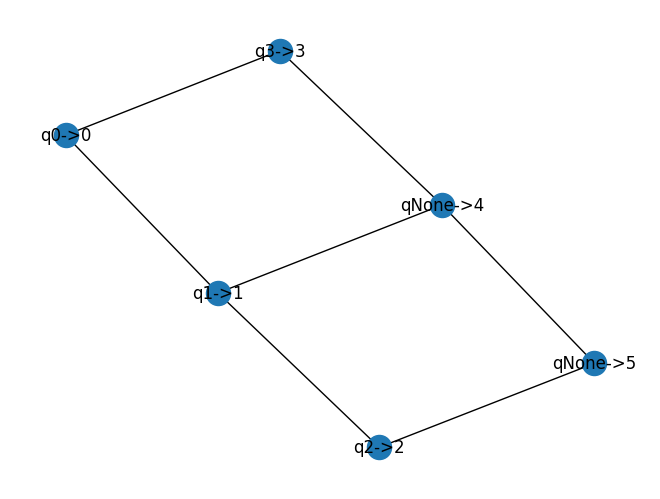

In [12]:
mapping = map_circuit(cuccaro, grid_hardware)
print('Mapping:', mapping)
draw_mapping(grid_hardware, mapping)

In [13]:
# Do not delete this cell
def validate_mapping(circuit, target_hardware, mapping):
    # Check other arguments
    assert isinstance(circuit, QuantumCircuit)
    assert isinstance(target_hardware, nx.Graph)
    assert isinstance(mapping, dict)
    qubits = frozenset(q for q in circuit.qubits)
    assert len(circuit.qubits) == len(qubits), 'Unsupported: circuits with multiple registers'
    assert all(isinstance(q, Qubit) for q in qubits)
    assert len(qubits) <= len(target_hardware.nodes), 'Not enough qubits in the hardware'
    assert all(isinstance(hw_q, int) for hw_q in target_hardware.nodes), 'Unsupported: non-int hardware qubit ids'
    # Check mapping keys
    assert all(isinstance(q, Qubit) for q in mapping.keys()), 'The keys of the mapping should be qiskit Qubits'
    assert len(qubits) == len(frozenset(mapping.keys())), 'Not all qubits (or too many) were mapped to hardware'
    assert qubits == frozenset(mapping.keys()), 'The mapping uses the wrong keys, they should be qubit._index for each qubit in the circuit'
    # Check mapping values
    assert all(isinstance(q, int) for q in mapping.values()), 'The values of the mapping should be integers (the nodes of target_hardware)'
    assert len(frozenset(mapping.values())) == len(mapping.values()), 'Duplicate values in mapping (hardware qubits): you may only map one circuit qubit to each hardware qubit'
    assert frozenset(mapping.values()).issubset(frozenset(target_hardware.nodes)), 'Some of the hardware qubits used do not exist on this hardware'
    assert len(target_hardware.nodes) >= len(frozenset(mapping.values())), 'More hardware qubits were used than exist'

def score_mapping(circuit, target_hardware, mapping):
    '''
    Computes a score that approximates the number of SWAPs needed for this mapping.

    Returns the tuple (your score, worst possible score).  Lower values are better.
    '''
    validate_mapping(circuit, target_hardware, mapping)

    ig = interaction_graph_from_circuit(circuit)
    shortest_paths = dict(nx.all_pairs_shortest_path_length(target_hardware))
    score = 0
    for q1, q2 in ig.edges:
        cnot_count = ig[q1][q2]['weight']
        hw_q1 = mapping[q1]
        hw_q2 = mapping[q2]
        swap_distance = shortest_paths[hw_q1][hw_q2] - 1
        score += swap_distance * 2 * cnot_count

    furthest = max(max(dist for dist in from_q.values())
                       for from_q in shortest_paths.values())
    cnot_count = sum(ig[edge[0]][edge[1]]['weight'] for edge in ig.edges)
    worst_case_score = (furthest-1) * 2 * cnot_count
    print(f'Your mapping score is {score}, better than the worst possible '
          f'of {worst_case_score}.')
    return score, worst_case_score

In [14]:
# You may modify this cell to test scores for your mapper on various circuits

mapping = map_circuit(cuccaro, grid_hardware)
score, worst = score_mapping(cuccaro, grid_hardware, mapping)

Your mapping score is 8, better than the worst possible of 64.


In [15]:
# # GV Cell
# # Do not delete this cell
# # The autograder will test the function map_circuit.
# # This test is worth most of the points for part 1
# _hardware = nx.path_graph(5)
# #draw_hardware_graph(_hardware)
# #_cuccaro4 = decomposed_adder_circuit(4)
# _cuccaro4 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\ncx q[1],q[2];\ncx q[1],q[0];\nh q[1];\ncx q[2],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[2],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[2];\ncx q[0],q[2];\nrz(pi/4) q[0];\nrz(-pi/4) q[2];\ncx q[0],q[2];\nrz(2.6375741) q[2];\nrx(pi) q[2];\nrz(2.6375741) q[2];\ncx q[0],q[2];\ncx q[1],q[3];\nh q[1];\ncx q[2],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[2],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[2];\ncx q[0],q[2];\nrz(pi/4) q[0];\nrz(-pi/4) q[2];\ncx q[0],q[2];\ncx q[1],q[0];\nrz(2.6375741) q[2];\nrx(pi) q[2];\nrz(2.6375741) q[2];\ncx q[1],q[2];\n')
# #display(_cuccaro4.draw(fold=-1))
# #draw_interaction_graph(interaction_graph_from_circuit(_cuccaro4))

# _mapping = map_circuit(_cuccaro4, _hardware)
# validate_mapping(_cuccaro4, _hardware, _mapping)
# score_mapping(_cuccaro4, _hardware, _mapping)
# print('PASS: Valid circuit mapping')
# draw_mapping(_hardware, _mapping)

In [16]:
# Do not delete this cell
# The autograder will test the function map_circuit.
# This test is worth most of the points for part 1
_hardware = nx.path_graph(5)
#_cuccaro4 = decomposed_adder_circuit(4)
_cuccaro4 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[4];\ncx q[1],q[2];\ncx q[1],q[0];\nh q[1];\ncx q[2],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[2],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[2];\ncx q[0],q[2];\nrz(pi/4) q[0];\nrz(-pi/4) q[2];\ncx q[0],q[2];\nrz(2.6375741) q[2];\nrx(pi) q[2];\nrz(2.6375741) q[2];\ncx q[0],q[2];\ncx q[1],q[3];\nh q[1];\ncx q[2],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[2],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[2];\ncx q[0],q[2];\nrz(pi/4) q[0];\nrz(-pi/4) q[2];\ncx q[0],q[2];\ncx q[1],q[0];\nrz(2.6375741) q[2];\nrx(pi) q[2];\nrz(2.6375741) q[2];\ncx q[1],q[2];\n')
_mapping = map_circuit(_cuccaro4, _hardware)
validate_mapping(_cuccaro4, _hardware, _mapping)
score_mapping(_cuccaro4, _hardware, _mapping)
print('PASS: Valid circuit mapping')

Your mapping score is 12, better than the worst possible of 108.
PASS: Valid circuit mapping


AssertionError: Not all qubits (or too many) were mapped to hardware

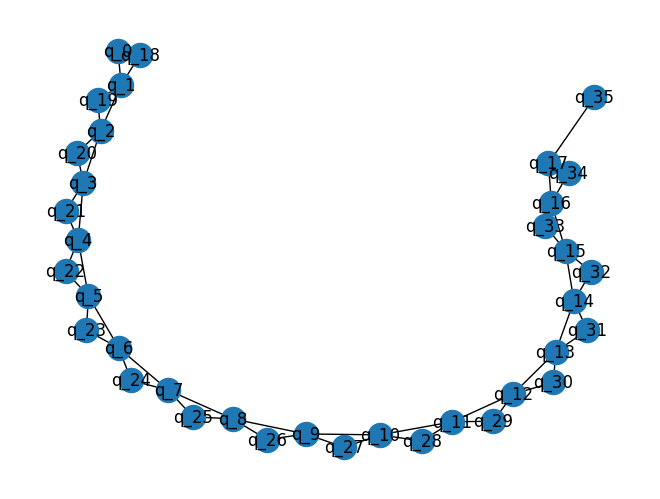

In [18]:
# GV Cell
# Do not delete this cell
# The autograder will test the function map_circuit.
_hardware = nx.grid_2d_graph(6, 6)
_hardware = nx.relabel_nodes(_hardware,
    {n: i for i, n in enumerate(_hardware.nodes)})
#_cuccaro36 = decomposed_adder_circuit(36)
_cuccaro36 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[36];\ncx q[1],q[18];\ncx q[1],q[0];\nh q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[18];\ncx q[0],q[18];\nrz(pi/4) q[0];\nrz(-pi/4) q[18];\ncx q[0],q[18];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\ncx q[0],q[18];\ncx q[2],q[19];\ncx q[2],q[1];\nh q[2];\ncx q[19],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[19],q[2];\nrz(pi/4) q[19];\nrz(-pi/4) q[2];\ncx q[1],q[2];\ncx q[1],q[19];\nrz(pi/4) q[1];\nrz(-pi/4) q[19];\ncx q[1],q[19];\nrz(2.6375741) q[19];\nrx(pi) q[19];\nrz(2.6375741) q[19];\ncx q[1],q[19];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\ncx q[3],q[20];\ncx q[3],q[2];\nh q[3];\ncx q[20],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[20],q[3];\nrz(pi/4) q[20];\nrz(-pi/4) q[3];\ncx q[2],q[3];\ncx q[2],q[20];\nrz(pi/4) q[2];\nrz(-pi/4) q[20];\ncx q[2],q[20];\nrz(2.6375741) q[20];\nrx(pi) q[20];\nrz(2.6375741) q[20];\ncx q[2],q[20];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\ncx q[4],q[21];\ncx q[4],q[3];\nh q[4];\ncx q[21],q[4];\nrz(-pi/4) q[4];\ncx q[3],q[4];\nrz(pi/4) q[4];\ncx q[21],q[4];\nrz(pi/4) q[21];\nrz(-pi/4) q[4];\ncx q[3],q[4];\ncx q[3],q[21];\nrz(-pi/4) q[21];\nrz(pi/4) q[3];\ncx q[3],q[21];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\ncx q[3],q[21];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\ncx q[5],q[22];\ncx q[5],q[4];\nh q[5];\ncx q[22],q[5];\nrz(-pi/4) q[5];\ncx q[4],q[5];\nrz(pi/4) q[5];\ncx q[22],q[5];\nrz(pi/4) q[22];\nrz(-pi/4) q[5];\ncx q[4],q[5];\ncx q[4],q[22];\nrz(-pi/4) q[22];\nrz(pi/4) q[4];\ncx q[4],q[22];\nrz(2.6375741) q[22];\nrx(pi) q[22];\nrz(2.6375741) q[22];\ncx q[4],q[22];\nrz(-5*pi/4) q[5];\nrx(pi/2) q[5];\nrz(pi/2) q[5];\ncx q[6],q[23];\ncx q[6],q[5];\nh q[6];\ncx q[23],q[6];\nrz(-pi/4) q[6];\ncx q[5],q[6];\nrz(pi/4) q[6];\ncx q[23],q[6];\nrz(pi/4) q[23];\nrz(-pi/4) q[6];\ncx q[5],q[6];\ncx q[5],q[23];\nrz(-pi/4) q[23];\nrz(pi/4) q[5];\ncx q[5],q[23];\nrz(2.6375741) q[23];\nrx(pi) q[23];\nrz(2.6375741) q[23];\ncx q[5],q[23];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\ncx q[7],q[24];\ncx q[7],q[6];\nh q[7];\ncx q[24],q[7];\nrz(-pi/4) q[7];\ncx q[6],q[7];\nrz(pi/4) q[7];\ncx q[24],q[7];\nrz(pi/4) q[24];\nrz(-pi/4) q[7];\ncx q[6],q[7];\ncx q[6],q[24];\nrz(-pi/4) q[24];\nrz(pi/4) q[6];\ncx q[6],q[24];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\ncx q[6],q[24];\nrz(-5*pi/4) q[7];\nrx(pi/2) q[7];\nrz(pi/2) q[7];\ncx q[8],q[25];\ncx q[8],q[7];\nh q[8];\ncx q[25],q[8];\nrz(-pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[8];\ncx q[25],q[8];\nrz(pi/4) q[25];\nrz(-pi/4) q[8];\ncx q[7],q[8];\ncx q[7],q[25];\nrz(-pi/4) q[25];\nrz(pi/4) q[7];\ncx q[7],q[25];\nrz(2.6375741) q[25];\nrx(pi) q[25];\nrz(2.6375741) q[25];\ncx q[7],q[25];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[9],q[26];\ncx q[9],q[8];\nh q[9];\ncx q[26],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[26],q[9];\nrz(pi/4) q[26];\nrz(-pi/4) q[9];\ncx q[8],q[9];\ncx q[8],q[26];\nrz(-pi/4) q[26];\nrz(pi/4) q[8];\ncx q[8],q[26];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\ncx q[8],q[26];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[10],q[27];\ncx q[10],q[9];\nh q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\ncx q[9],q[10];\nrz(pi/4) q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\nrz(pi/4) q[27];\ncx q[9],q[10];\nrz(-5*pi/4) q[10];\nrx(pi/2) q[10];\nrz(pi/2) q[10];\ncx q[9],q[27];\nrz(-pi/4) q[27];\nrz(pi/4) q[9];\ncx q[9],q[27];\nrz(2.6375741) q[27];\nrx(pi) q[27];\nrz(2.6375741) q[27];\ncx q[9],q[27];\ncx q[11],q[28];\ncx q[11],q[10];\nh q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(pi/4) q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nrz(pi/4) q[28];\ncx q[10],q[28];\nrz(pi/4) q[10];\nrz(-pi/4) q[28];\ncx q[10],q[28];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\ncx q[10],q[28];\ncx q[12],q[29];\ncx q[12],q[11];\nh q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(pi/4) q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(-5*pi/4) q[12];\nrx(pi/2) q[12];\nrz(pi/2) q[12];\nrz(pi/4) q[29];\ncx q[11],q[29];\nrz(pi/4) q[11];\nrz(-pi/4) q[29];\ncx q[11],q[29];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\ncx q[11],q[29];\ncx q[13],q[30];\ncx q[13],q[12];\nh q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(pi/4) q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[30];\ncx q[12],q[30];\nrz(pi/4) q[12];\nrz(-pi/4) q[30];\ncx q[12],q[30];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[12],q[30];\ncx q[14],q[31];\ncx q[14],q[13];\nh q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(pi/4) q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(-5*pi/4) q[14];\nrx(pi/2) q[14];\nrz(pi/2) q[14];\nrz(pi/4) q[31];\ncx q[13],q[31];\nrz(pi/4) q[13];\nrz(-pi/4) q[31];\ncx q[13],q[31];\nrz(2.6375741) q[31];\nrx(pi) q[31];\nrz(2.6375741) q[31];\ncx q[13],q[31];\ncx q[15],q[32];\ncx q[15],q[14];\nh q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\nrz(pi/4) q[32];\ncx q[14],q[32];\nrz(pi/4) q[14];\nrz(-pi/4) q[32];\ncx q[14],q[32];\nrz(2.6375741) q[32];\nrx(pi) q[32];\nrz(2.6375741) q[32];\ncx q[14],q[32];\ncx q[16],q[33];\ncx q[16],q[15];\nh q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\nrz(pi/4) q[33];\ncx q[15],q[33];\nrz(pi/4) q[15];\nrz(-pi/4) q[33];\ncx q[15],q[33];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[15],q[33];\ncx q[17],q[34];\ncx q[17],q[16];\nh q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(pi/4) q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(-5*pi/4) q[17];\nrx(pi/2) q[17];\nrz(pi/2) q[17];\nrz(pi/4) q[34];\ncx q[16],q[34];\nrz(pi/4) q[16];\nrz(-pi/4) q[34];\ncx q[16],q[34];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\ncx q[16],q[34];\ncx q[17],q[35];\nh q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(pi/4) q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(-5*pi/4) q[17];\nrx(pi/2) q[17];\nrz(pi/2) q[17];\nrz(pi/4) q[34];\ncx q[16],q[34];\nrz(pi/4) q[16];\nrz(-pi/4) q[34];\ncx q[16],q[34];\ncx q[17],q[16];\nh q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\nrz(pi/4) q[33];\ncx q[15],q[33];\nrz(pi/4) q[15];\nrz(-pi/4) q[33];\ncx q[15],q[33];\ncx q[16],q[15];\nh q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\nrz(pi/4) q[32];\ncx q[14],q[32];\nrz(pi/4) q[14];\nrz(-pi/4) q[32];\ncx q[14],q[32];\ncx q[15],q[14];\nh q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(pi/4) q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(-5*pi/4) q[14];\nrx(pi/2) q[14];\nrz(pi/2) q[14];\nrz(pi/4) q[31];\ncx q[13],q[31];\nrz(pi/4) q[13];\nrz(-pi/4) q[31];\ncx q[13],q[31];\ncx q[14],q[13];\nh q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(pi/4) q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[30];\ncx q[12],q[30];\nrz(pi/4) q[12];\nrz(-pi/4) q[30];\ncx q[12],q[30];\ncx q[13],q[12];\nh q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(pi/4) q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(-5*pi/4) q[12];\nrx(pi/2) q[12];\nrz(pi/2) q[12];\nrz(pi/4) q[29];\ncx q[11],q[29];\nrz(pi/4) q[11];\nrz(-pi/4) q[29];\ncx q[11],q[29];\ncx q[12],q[11];\nh q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(pi/4) q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nrz(pi/4) q[28];\ncx q[10],q[28];\nrz(pi/4) q[10];\nrz(-pi/4) q[28];\ncx q[10],q[28];\ncx q[11],q[10];\nh q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\ncx q[11],q[28];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\ncx q[12],q[29];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[13],q[30];\nrz(2.6375741) q[31];\nrx(pi) q[31];\nrz(2.6375741) q[31];\ncx q[14],q[31];\nrz(2.6375741) q[32];\nrx(pi) q[32];\nrz(2.6375741) q[32];\ncx q[15],q[32];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[16],q[33];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\ncx q[17],q[34];\ncx q[9],q[10];\nrz(pi/4) q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\nrz(pi/4) q[27];\ncx q[9],q[10];\nrz(-5*pi/4) q[10];\nrx(pi/2) q[10];\nrz(pi/2) q[10];\ncx q[9],q[27];\nrz(-pi/4) q[27];\nrz(pi/4) q[9];\ncx q[9],q[27];\ncx q[10],q[9];\nrz(2.6375741) q[27];\nrx(pi) q[27];\nrz(2.6375741) q[27];\ncx q[10],q[27];\nh q[9];\ncx q[26],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[26],q[9];\nrz(pi/4) q[26];\nrz(-pi/4) q[9];\ncx q[8],q[9];\ncx q[8],q[26];\nrz(-pi/4) q[26];\nrz(pi/4) q[8];\ncx q[8],q[26];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[9],q[8];\nh q[8];\ncx q[25],q[8];\nrz(-pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[8];\ncx q[25],q[8];\nrz(pi/4) q[25];\nrz(-pi/4) q[8];\ncx q[7],q[8];\ncx q[7],q[25];\nrz(-pi/4) q[25];\nrz(pi/4) q[7];\ncx q[7],q[25];\nrz(2.6375741) q[25];\nrx(pi) q[25];\nrz(2.6375741) q[25];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[8],q[7];\nh q[7];\ncx q[24],q[7];\nrz(-pi/4) q[7];\ncx q[6],q[7];\nrz(pi/4) q[7];\ncx q[24],q[7];\nrz(pi/4) q[24];\nrz(-pi/4) q[7];\ncx q[6],q[7];\ncx q[6],q[24];\nrz(-pi/4) q[24];\nrz(pi/4) q[6];\ncx q[6],q[24];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\nrz(-5*pi/4) q[7];\nrx(pi/2) q[7];\nrz(pi/2) q[7];\ncx q[7],q[6];\nh q[6];\ncx q[23],q[6];\nrz(-pi/4) q[6];\ncx q[5],q[6];\nrz(pi/4) q[6];\ncx q[23],q[6];\nrz(pi/4) q[23];\nrz(-pi/4) q[6];\ncx q[5],q[6];\ncx q[5],q[23];\nrz(-pi/4) q[23];\nrz(pi/4) q[5];\ncx q[5],q[23];\nrz(2.6375741) q[23];\nrx(pi) q[23];\nrz(2.6375741) q[23];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\ncx q[6],q[5];\nh q[5];\ncx q[22],q[5];\nrz(-pi/4) q[5];\ncx q[4],q[5];\nrz(pi/4) q[5];\ncx q[22],q[5];\nrz(pi/4) q[22];\nrz(-pi/4) q[5];\ncx q[4],q[5];\ncx q[4],q[22];\nrz(-pi/4) q[22];\nrz(pi/4) q[4];\ncx q[4],q[22];\nrz(2.6375741) q[22];\nrx(pi) q[22];\nrz(2.6375741) q[22];\nrz(-5*pi/4) q[5];\nrx(pi/2) q[5];\nrz(pi/2) q[5];\ncx q[5],q[4];\nh q[4];\ncx q[21],q[4];\nrz(-pi/4) q[4];\ncx q[3],q[4];\nrz(pi/4) q[4];\ncx q[21],q[4];\nrz(pi/4) q[21];\nrz(-pi/4) q[4];\ncx q[3],q[4];\ncx q[3],q[21];\nrz(-pi/4) q[21];\nrz(pi/4) q[3];\ncx q[3],q[21];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\ncx q[4],q[3];\nh q[3];\ncx q[20],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[20],q[3];\nrz(pi/4) q[20];\nrz(-pi/4) q[3];\ncx q[2],q[3];\ncx q[2],q[20];\nrz(pi/4) q[2];\nrz(-pi/4) q[20];\ncx q[2],q[20];\nrz(2.6375741) q[20];\nrx(pi) q[20];\nrz(2.6375741) q[20];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\ncx q[3],q[2];\nh q[2];\ncx q[19],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[19],q[2];\nrz(pi/4) q[19];\nrz(-pi/4) q[2];\ncx q[1],q[2];\ncx q[1],q[19];\nrz(pi/4) q[1];\nrz(-pi/4) q[19];\ncx q[1],q[19];\nrz(2.6375741) q[19];\nrx(pi) q[19];\nrz(2.6375741) q[19];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\ncx q[2],q[1];\nh q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[18];\ncx q[0],q[18];\nrz(pi/4) q[0];\nrz(-pi/4) q[18];\ncx q[0],q[18];\ncx q[1],q[0];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\ncx q[1],q[18];\ncx q[2],q[19];\ncx q[3],q[20];\ncx q[4],q[21];\ncx q[5],q[22];\ncx q[6],q[23];\ncx q[7],q[24];\ncx q[8],q[25];\ncx q[9],q[26];\n')
draw_interaction_graph(interaction_graph_from_circuit(_cuccaro36))
_mapping = map_circuit(_cuccaro36, _hardware)
validate_mapping(_cuccaro36, _hardware, _mapping)
_score, _worst = score_mapping(_cuccaro36, _hardware, _mapping)
assert _worst == 5220, 'internal error'
assert _score <= 1600, 'score is above 1600, try improving the mapping by placing pairs of qubits with many CNOTs close together'
print('PASS: Score is under 1600 (see if you can beat our solution of 210)')

In [ ]:
# Do not delete this cell
# The autograder will test the function map_circuit.
_hardware = nx.grid_2d_graph(6, 6)
_hardware = nx.relabel_nodes(_hardware,
    {n: i for i, n in enumerate(_hardware.nodes)})
#_cuccaro36 = decomposed_adder_circuit(36)
_cuccaro36 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[36];\ncx q[1],q[18];\ncx q[1],q[0];\nh q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[18];\ncx q[0],q[18];\nrz(pi/4) q[0];\nrz(-pi/4) q[18];\ncx q[0],q[18];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\ncx q[0],q[18];\ncx q[2],q[19];\ncx q[2],q[1];\nh q[2];\ncx q[19],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[19],q[2];\nrz(pi/4) q[19];\nrz(-pi/4) q[2];\ncx q[1],q[2];\ncx q[1],q[19];\nrz(pi/4) q[1];\nrz(-pi/4) q[19];\ncx q[1],q[19];\nrz(2.6375741) q[19];\nrx(pi) q[19];\nrz(2.6375741) q[19];\ncx q[1],q[19];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\ncx q[3],q[20];\ncx q[3],q[2];\nh q[3];\ncx q[20],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[20],q[3];\nrz(pi/4) q[20];\nrz(-pi/4) q[3];\ncx q[2],q[3];\ncx q[2],q[20];\nrz(pi/4) q[2];\nrz(-pi/4) q[20];\ncx q[2],q[20];\nrz(2.6375741) q[20];\nrx(pi) q[20];\nrz(2.6375741) q[20];\ncx q[2],q[20];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\ncx q[4],q[21];\ncx q[4],q[3];\nh q[4];\ncx q[21],q[4];\nrz(-pi/4) q[4];\ncx q[3],q[4];\nrz(pi/4) q[4];\ncx q[21],q[4];\nrz(pi/4) q[21];\nrz(-pi/4) q[4];\ncx q[3],q[4];\ncx q[3],q[21];\nrz(-pi/4) q[21];\nrz(pi/4) q[3];\ncx q[3],q[21];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\ncx q[3],q[21];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\ncx q[5],q[22];\ncx q[5],q[4];\nh q[5];\ncx q[22],q[5];\nrz(-pi/4) q[5];\ncx q[4],q[5];\nrz(pi/4) q[5];\ncx q[22],q[5];\nrz(pi/4) q[22];\nrz(-pi/4) q[5];\ncx q[4],q[5];\ncx q[4],q[22];\nrz(-pi/4) q[22];\nrz(pi/4) q[4];\ncx q[4],q[22];\nrz(2.6375741) q[22];\nrx(pi) q[22];\nrz(2.6375741) q[22];\ncx q[4],q[22];\nrz(-5*pi/4) q[5];\nrx(pi/2) q[5];\nrz(pi/2) q[5];\ncx q[6],q[23];\ncx q[6],q[5];\nh q[6];\ncx q[23],q[6];\nrz(-pi/4) q[6];\ncx q[5],q[6];\nrz(pi/4) q[6];\ncx q[23],q[6];\nrz(pi/4) q[23];\nrz(-pi/4) q[6];\ncx q[5],q[6];\ncx q[5],q[23];\nrz(-pi/4) q[23];\nrz(pi/4) q[5];\ncx q[5],q[23];\nrz(2.6375741) q[23];\nrx(pi) q[23];\nrz(2.6375741) q[23];\ncx q[5],q[23];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\ncx q[7],q[24];\ncx q[7],q[6];\nh q[7];\ncx q[24],q[7];\nrz(-pi/4) q[7];\ncx q[6],q[7];\nrz(pi/4) q[7];\ncx q[24],q[7];\nrz(pi/4) q[24];\nrz(-pi/4) q[7];\ncx q[6],q[7];\ncx q[6],q[24];\nrz(-pi/4) q[24];\nrz(pi/4) q[6];\ncx q[6],q[24];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\ncx q[6],q[24];\nrz(-5*pi/4) q[7];\nrx(pi/2) q[7];\nrz(pi/2) q[7];\ncx q[8],q[25];\ncx q[8],q[7];\nh q[8];\ncx q[25],q[8];\nrz(-pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[8];\ncx q[25],q[8];\nrz(pi/4) q[25];\nrz(-pi/4) q[8];\ncx q[7],q[8];\ncx q[7],q[25];\nrz(-pi/4) q[25];\nrz(pi/4) q[7];\ncx q[7],q[25];\nrz(2.6375741) q[25];\nrx(pi) q[25];\nrz(2.6375741) q[25];\ncx q[7],q[25];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[9],q[26];\ncx q[9],q[8];\nh q[9];\ncx q[26],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[26],q[9];\nrz(pi/4) q[26];\nrz(-pi/4) q[9];\ncx q[8],q[9];\ncx q[8],q[26];\nrz(-pi/4) q[26];\nrz(pi/4) q[8];\ncx q[8],q[26];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\ncx q[8],q[26];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[10],q[27];\ncx q[10],q[9];\nh q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\ncx q[9],q[10];\nrz(pi/4) q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\nrz(pi/4) q[27];\ncx q[9],q[10];\nrz(-5*pi/4) q[10];\nrx(pi/2) q[10];\nrz(pi/2) q[10];\ncx q[9],q[27];\nrz(-pi/4) q[27];\nrz(pi/4) q[9];\ncx q[9],q[27];\nrz(2.6375741) q[27];\nrx(pi) q[27];\nrz(2.6375741) q[27];\ncx q[9],q[27];\ncx q[11],q[28];\ncx q[11],q[10];\nh q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(pi/4) q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nrz(pi/4) q[28];\ncx q[10],q[28];\nrz(pi/4) q[10];\nrz(-pi/4) q[28];\ncx q[10],q[28];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\ncx q[10],q[28];\ncx q[12],q[29];\ncx q[12],q[11];\nh q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(pi/4) q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(-5*pi/4) q[12];\nrx(pi/2) q[12];\nrz(pi/2) q[12];\nrz(pi/4) q[29];\ncx q[11],q[29];\nrz(pi/4) q[11];\nrz(-pi/4) q[29];\ncx q[11],q[29];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\ncx q[11],q[29];\ncx q[13],q[30];\ncx q[13],q[12];\nh q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(pi/4) q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[30];\ncx q[12],q[30];\nrz(pi/4) q[12];\nrz(-pi/4) q[30];\ncx q[12],q[30];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[12],q[30];\ncx q[14],q[31];\ncx q[14],q[13];\nh q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(pi/4) q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(-5*pi/4) q[14];\nrx(pi/2) q[14];\nrz(pi/2) q[14];\nrz(pi/4) q[31];\ncx q[13],q[31];\nrz(pi/4) q[13];\nrz(-pi/4) q[31];\ncx q[13],q[31];\nrz(2.6375741) q[31];\nrx(pi) q[31];\nrz(2.6375741) q[31];\ncx q[13],q[31];\ncx q[15],q[32];\ncx q[15],q[14];\nh q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\nrz(pi/4) q[32];\ncx q[14],q[32];\nrz(pi/4) q[14];\nrz(-pi/4) q[32];\ncx q[14],q[32];\nrz(2.6375741) q[32];\nrx(pi) q[32];\nrz(2.6375741) q[32];\ncx q[14],q[32];\ncx q[16],q[33];\ncx q[16],q[15];\nh q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\nrz(pi/4) q[33];\ncx q[15],q[33];\nrz(pi/4) q[15];\nrz(-pi/4) q[33];\ncx q[15],q[33];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[15],q[33];\ncx q[17],q[34];\ncx q[17],q[16];\nh q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(pi/4) q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(-5*pi/4) q[17];\nrx(pi/2) q[17];\nrz(pi/2) q[17];\nrz(pi/4) q[34];\ncx q[16],q[34];\nrz(pi/4) q[16];\nrz(-pi/4) q[34];\ncx q[16],q[34];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\ncx q[16],q[34];\ncx q[17],q[35];\nh q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(pi/4) q[17];\ncx q[34],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(-5*pi/4) q[17];\nrx(pi/2) q[17];\nrz(pi/2) q[17];\nrz(pi/4) q[34];\ncx q[16],q[34];\nrz(pi/4) q[16];\nrz(-pi/4) q[34];\ncx q[16],q[34];\ncx q[17],q[16];\nh q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[33],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\nrz(pi/4) q[33];\ncx q[15],q[33];\nrz(pi/4) q[15];\nrz(-pi/4) q[33];\ncx q[15],q[33];\ncx q[16],q[15];\nh q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[15];\ncx q[32],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\nrz(pi/4) q[32];\ncx q[14],q[32];\nrz(pi/4) q[14];\nrz(-pi/4) q[32];\ncx q[14],q[32];\ncx q[15],q[14];\nh q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(pi/4) q[14];\ncx q[31],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(-5*pi/4) q[14];\nrx(pi/2) q[14];\nrz(pi/2) q[14];\nrz(pi/4) q[31];\ncx q[13],q[31];\nrz(pi/4) q[13];\nrz(-pi/4) q[31];\ncx q[13],q[31];\ncx q[14],q[13];\nh q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(pi/4) q[13];\ncx q[30],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[30];\ncx q[12],q[30];\nrz(pi/4) q[12];\nrz(-pi/4) q[30];\ncx q[12],q[30];\ncx q[13],q[12];\nh q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(pi/4) q[12];\ncx q[29],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(-5*pi/4) q[12];\nrx(pi/2) q[12];\nrz(pi/2) q[12];\nrz(pi/4) q[29];\ncx q[11],q[29];\nrz(pi/4) q[11];\nrz(-pi/4) q[29];\ncx q[11],q[29];\ncx q[12],q[11];\nh q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(pi/4) q[11];\ncx q[28],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nrz(pi/4) q[28];\ncx q[10],q[28];\nrz(pi/4) q[10];\nrz(-pi/4) q[28];\ncx q[10],q[28];\ncx q[11],q[10];\nh q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\ncx q[11],q[28];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\ncx q[12],q[29];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[13],q[30];\nrz(2.6375741) q[31];\nrx(pi) q[31];\nrz(2.6375741) q[31];\ncx q[14],q[31];\nrz(2.6375741) q[32];\nrx(pi) q[32];\nrz(2.6375741) q[32];\ncx q[15],q[32];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[16],q[33];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\ncx q[17],q[34];\ncx q[9],q[10];\nrz(pi/4) q[10];\ncx q[27],q[10];\nrz(-pi/4) q[10];\nrz(pi/4) q[27];\ncx q[9],q[10];\nrz(-5*pi/4) q[10];\nrx(pi/2) q[10];\nrz(pi/2) q[10];\ncx q[9],q[27];\nrz(-pi/4) q[27];\nrz(pi/4) q[9];\ncx q[9],q[27];\ncx q[10],q[9];\nrz(2.6375741) q[27];\nrx(pi) q[27];\nrz(2.6375741) q[27];\ncx q[10],q[27];\nh q[9];\ncx q[26],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[26],q[9];\nrz(pi/4) q[26];\nrz(-pi/4) q[9];\ncx q[8],q[9];\ncx q[8],q[26];\nrz(-pi/4) q[26];\nrz(pi/4) q[8];\ncx q[8],q[26];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[9],q[8];\nh q[8];\ncx q[25],q[8];\nrz(-pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[8];\ncx q[25],q[8];\nrz(pi/4) q[25];\nrz(-pi/4) q[8];\ncx q[7],q[8];\ncx q[7],q[25];\nrz(-pi/4) q[25];\nrz(pi/4) q[7];\ncx q[7],q[25];\nrz(2.6375741) q[25];\nrx(pi) q[25];\nrz(2.6375741) q[25];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[8],q[7];\nh q[7];\ncx q[24],q[7];\nrz(-pi/4) q[7];\ncx q[6],q[7];\nrz(pi/4) q[7];\ncx q[24],q[7];\nrz(pi/4) q[24];\nrz(-pi/4) q[7];\ncx q[6],q[7];\ncx q[6],q[24];\nrz(-pi/4) q[24];\nrz(pi/4) q[6];\ncx q[6],q[24];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\nrz(-5*pi/4) q[7];\nrx(pi/2) q[7];\nrz(pi/2) q[7];\ncx q[7],q[6];\nh q[6];\ncx q[23],q[6];\nrz(-pi/4) q[6];\ncx q[5],q[6];\nrz(pi/4) q[6];\ncx q[23],q[6];\nrz(pi/4) q[23];\nrz(-pi/4) q[6];\ncx q[5],q[6];\ncx q[5],q[23];\nrz(-pi/4) q[23];\nrz(pi/4) q[5];\ncx q[5],q[23];\nrz(2.6375741) q[23];\nrx(pi) q[23];\nrz(2.6375741) q[23];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\ncx q[6],q[5];\nh q[5];\ncx q[22],q[5];\nrz(-pi/4) q[5];\ncx q[4],q[5];\nrz(pi/4) q[5];\ncx q[22],q[5];\nrz(pi/4) q[22];\nrz(-pi/4) q[5];\ncx q[4],q[5];\ncx q[4],q[22];\nrz(-pi/4) q[22];\nrz(pi/4) q[4];\ncx q[4],q[22];\nrz(2.6375741) q[22];\nrx(pi) q[22];\nrz(2.6375741) q[22];\nrz(-5*pi/4) q[5];\nrx(pi/2) q[5];\nrz(pi/2) q[5];\ncx q[5],q[4];\nh q[4];\ncx q[21],q[4];\nrz(-pi/4) q[4];\ncx q[3],q[4];\nrz(pi/4) q[4];\ncx q[21],q[4];\nrz(pi/4) q[21];\nrz(-pi/4) q[4];\ncx q[3],q[4];\ncx q[3],q[21];\nrz(-pi/4) q[21];\nrz(pi/4) q[3];\ncx q[3],q[21];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\ncx q[4],q[3];\nh q[3];\ncx q[20],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[20],q[3];\nrz(pi/4) q[20];\nrz(-pi/4) q[3];\ncx q[2],q[3];\ncx q[2],q[20];\nrz(pi/4) q[2];\nrz(-pi/4) q[20];\ncx q[2],q[20];\nrz(2.6375741) q[20];\nrx(pi) q[20];\nrz(2.6375741) q[20];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\ncx q[3],q[2];\nh q[2];\ncx q[19],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[19],q[2];\nrz(pi/4) q[19];\nrz(-pi/4) q[2];\ncx q[1],q[2];\ncx q[1],q[19];\nrz(pi/4) q[1];\nrz(-pi/4) q[19];\ncx q[1],q[19];\nrz(2.6375741) q[19];\nrx(pi) q[19];\nrz(2.6375741) q[19];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\ncx q[2],q[1];\nh q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[18],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[18];\ncx q[0],q[18];\nrz(pi/4) q[0];\nrz(-pi/4) q[18];\ncx q[0],q[18];\ncx q[1],q[0];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\ncx q[1],q[18];\ncx q[2],q[19];\ncx q[3],q[20];\ncx q[4],q[21];\ncx q[5],q[22];\ncx q[6],q[23];\ncx q[7],q[24];\ncx q[8],q[25];\ncx q[9],q[26];\n')
_mapping = map_circuit(_cuccaro36, _hardware)
validate_mapping(_cuccaro36, _hardware, _mapping)
_score, _worst = score_mapping(_cuccaro36, _hardware, _mapping)
assert _worst == 5220, 'internal error'
assert _score <= 1600, 'score is above 1600, try improving the mapping by placing pairs of qubits with many CNOTs close together'
print('PASS: Score is under 1600 (see if you can beat our solution of 210)')

In [ ]:
# Do not delete this cell
# The autograder will test the function map_circuit.
# Hidden tests

# 2. Routing 2 Qubit Interactions

Your second task is to route two qubit interactions. If two qubits are not adjacent in hardware, add in SWAPs (generate a new circuit with the SWAP gates!) to make them adjacent, execute the desired gate, and the add SWAPs to return them to their originial position. You should choose paths which use as few SWAPs as possible. The output circuit should only contain gates (SWAPs and CNOTs) executed on pairs of qubits that are adjacent in the hardware graph (and also any single-qubit gates from the original circuit).

Make sure your code runs quickly.  Each test shouldn't run longer than a few seconds and 30 seconds will timeout the grader.

In [19]:
####Solution Cell
def route_circuit(quantum_circuit:QuantumCircuit, target_hardware:nx.Graph,
                  mapping:Dict[Qubit, int]) -> QuantumCircuit:
    '''
    This function should take an input program given as a
    qiskit.QuantumCircuit, a target hardware, given as a networkx
    graph, and a mapping (the dictionary from part 2) and return a
    new QuantumCircuit with additional operations added in.  We expect
    you to SWAP there and SWAP back so the mapping need not be modified,
    however more efficient implementations are welcome (see the
    bonus challenge in part 4).
    '''
    ### YOUR SOLUTION IN THIS FUNCTION

    new_circuit = QuantumCircuit(len(target_hardware.nodes)-1)

    # YOUR CODE HERE
    # Hint:
    # To copy a single-qubit gate:
    #     instr = quantum_circuit[i]
    #     circuit_qubit_list = instr.qubits
    #     hardware_qubit_id = ...
    #     new_circuit.append(instr.operation, [hardware_qubit_id], instr.clbits)
    # To copy a two-qubit gate:
    #     new_circuit.append(instr.operation, [hardware_qubit1_id, hardware_qubit2_id], instr.clbits)
    # new_circuit.cx(0,1)
    # new_circuit.cx(1,0)
    # new_circuit.cx(1,2)
    # new_circuit.cx(2,1)
    # for edge in target_hardware.edges:
    #   print(edge)

    ###################Original###################Original###################Original###################Original###################Original
    def checkIfAdjacentNodes(node1, node2):
      if node1 in target_hardware.nodes and node2 in target_hardware.nodes:
        if target_hardware.has_edge(node1, node2):
          return True
      return False

    # def findAdjacentNodes(node):
    #   adjacentNodes = []
    #   for edge in target_hardware.edges:
    #     if node in edge:
    #       if edge[0] == node:
    #         adjacentNodes.append(edge[1])
    #       else:
    #         adjacentNodes.append(edge[0])
    #   return adjacentNodes

    # for instr in quantum_circuit:
    #   print(instr)
    #   if len(instr.qubits) == 1:
    #     circuit_qubit_list = instr.qubits
    #     hardware_qubit_id = mapping[circuit_qubit_list[0]]
    #     #print(hardware_qubit_id)
    #     new_circuit.append(instr.operation, [hardware_qubit_id], instr.clbits)
    #   if len(instr.qubits) == 2:
    #     circuit_qubit_list = instr.qubits

    #     print(circuit_qubit_list[0]._index, "and ", circuit_qubit_list[1]._index, "circuit qubits are used")

    #     hardware_qubit1_id = mapping[circuit_qubit_list[0]]
    #     hardware_qubit2_id = mapping[circuit_qubit_list[1]]
    #     checkIsAdjacent = checkIfAdjacentNodes(hardware_qubit1_id, hardware_qubit2_id)
    #     if not checkIsAdjacent:
    #       ## Add Swap there
    #       print(hardware_qubit1_id, "and ", hardware_qubit2_id, "are not an adjacent hardware qubits")
    #       print("Add Swap there")
    #       adjacentNodes1 = findAdjacentNodes(hardware_qubit1_id)
    #       new_circuit.swap(circuit_qubit_list[0]._index,circuit_qubit_list[1]._index)

    #     new_circuit.append(instr.operation, [hardware_qubit1_id, hardware_qubit2_id], instr.clbits)
    #     if not checkIsAdjacent:
    #       ## Add Swap back
    #       new_circuit.swap(circuit_qubit_list[1]._index,circuit_qubit_list[0]._index)

    # new_circuit.h(0)
    # new_circuit.swap(0,1)
    # instr = new_circuit[0]
    # print(instr)
    # print(instr.operation)
    #new_circuit.append(instr.operation, [0, 1], instr.clbits)
    ###################Original###################Original###################Original###################Original###################Original

    ##################Temp###################Temp###################Temp###################Temp###################Temp###################Temp
    for instr in quantum_circuit:
      print(instr.operation)

      if len(instr.qubits) == 1:
        circuit_qubit_list = instr.qubits
        print("Single Qubits:", circuit_qubit_list[0]._index, "circuit qubit is used")
        hardware_qubit_id = mapping[circuit_qubit_list[0]]
        #print(hardware_qubit_id)
        new_circuit.append(instr.operation, [circuit_qubit_list[0]._index], instr.clbits)
      elif len(instr.qubits) == 2:
        circuit_qubit_list = instr.qubits
        print("Two Qubits:", circuit_qubit_list[0]._index, "and", circuit_qubit_list[1]._index, "circuit qubits are used. ", end="")
        hardware_qubit1_id = mapping[circuit_qubit_list[0]]
        hardware_qubit2_id = mapping[circuit_qubit_list[1]]
        checkIsAdjacent = checkIfAdjacentNodes(hardware_qubit1_id, hardware_qubit2_id)
        if not checkIsAdjacent:
          ## Add Swap there
          print("Hardware qubits:",hardware_qubit1_id, "and", hardware_qubit2_id, "are not an adjacent and do SWAP")
          #print("Add Swap there")
          #adjacentNodes1 = findAdjacentNodes(hardware_qubit1_id)
          # new_circuit.swap(circuit_qubit_list[0]._index,circuit_qubit_list[1]._index)
          # new_circuit.append(instr.operation, [circuit_qubit_list[0]._index, circuit_qubit_list[1]._index], instr.clbits)
          new_circuit.swap(1,2)
          new_circuit.append(instr.operation, [0,2], instr.clbits)
          new_circuit.swap(1,2)
          ## Add Swap back
          #print("Add Swap back")
        elif checkIsAdjacent:
          print("Hardware qubits:",hardware_qubit1_id, "and", hardware_qubit2_id, "are adjacent")
          new_circuit.append(instr.operation, [circuit_qubit_list[0]._index, circuit_qubit_list[1]._index], instr.clbits)

    ###################Temp###################Temp###################Temp###################Temp###################Temp###################Temp

    new_circuit = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[6];\ncx q[0],q[1];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\nswap q[1],q[0];\ncx q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\nswap q[1],q[0];\ncx q[2],q[1];\nswap q[1],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\ncx q[2],q[1];\nrz(pi/4) q[2];\nrz(-pi/4) q[1];\ncx q[2],q[1];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[2],q[1];\ncx q[3],q[4];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[3],q[2];\nswap q[2],q[1];\nswap q[1],q[0];\nh q[3];\ncx q[4],q[3];\nrz(-pi/4) q[3];\nswap q[2],q[3];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nrz(pi/4) q[3];\ncx q[4],q[3];\nrz(-pi/4) q[3];\nswap q[2],q[3];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\nrz(pi/4) q[4];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[0];\nrz(-pi/4) q[4];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nswap q[4],q[5];\ncx q[3],q[4];\nswap q[4],q[5];\nh q[3];\ncx q[4],q[3];\nrz(-pi/4) q[3];\nswap q[2],q[3];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nrz(pi/4) q[3];\ncx q[4],q[3];\nrz(-pi/4) q[3];\nswap q[2],q[3];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\nrz(pi/4) q[4];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[0];\nrz(-pi/4) q[4];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[3],q[2];\nswap q[2],q[1];\nswap q[1],q[0];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\nswap q[1],q[0];\ncx q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\nswap q[1],q[0];\ncx q[2],q[1];\nswap q[1],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\ncx q[2],q[1];\nrz(pi/4) q[2];\nrz(-pi/4) q[1];\ncx q[2],q[1];\nswap q[1],q[2];\ncx q[0],q[1];\nswap q[1],q[2];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[3],q[4];\n')
    return new_circuit

Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 1 and 2 circuit qubits are used. Hardware qubits: 1 and 2 are adjacent
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 1 and 0 circuit qubits are used. Hardware qubits: 1 and 0 are adjacent
Instruction(name='h', num_qubits=1, num_clbits=0, params=[])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 2 and 1 circuit qubits are used. Hardware qubits: 2 and 1 are adjacent
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-0.7853981633974483])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 0 and 1 circuit qubits are used. Hardware qubits: 0 and 1 are adjacent
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.7853981633974483])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 2 and 1

global phase: 5π/4
          ┌───┐                                                                            ┌─────────┐                                                                                                              ┌───┐       
q_0: ─────┤ X ├────────────────────────■────────────────────────────────■───────────────■──┤ Rz(π/2) ├───────────────────────────────────────■────────────────────────────────■───────────────■────────────────■────┤ X ├───────
          └─┬─┘┌───┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │  └──┬───┬──┘               ┌───┐┌───┐┌──────────┐┌─┴─┐┌─────────┐┌───┐┌──────────┐┌─┴─┐┌─────────┐  │     ┌───┐      │    └─┬─┘       
q_1: ──■────■──┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├───────────────■──┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├──┼─────┤ H ├──────┼──────■──────■──
     ┌─┴─┐     └───┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────┘┌─┴─┐┌──┴───┴───┐┌───────┐  │  └───┘└─┬─┘└──────────┘└───┘└─────────┘└─┬─┘├─────────┬┘└───┘└─────────┘┌─┴─┐┌──┴───┴───┐┌─┴─┐┌───────┐┌─┴─┐
q_2: ┤ X ├────────────■────────────────────────────────■──┤ Rz(π/4) ├─────────────────┤ X ├┤ Rz(-π/4) ├┤ Rx(π) ├──┼─────────■────────────────────────────────■──┤ Rz(π/4) ├─────────────────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rx(π) ├┤ X ├
     └───┘                                                └─────────┘                 └───┘└──────────┘└───────┘┌─┴─┐                                           └─────────┘                 └───┘└──────────┘└───┘└───────┘└───┘
q_3: ───────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                └───┘

┌───┐┌───┐┌──────────┐           ┌─────────┐┌───┐┌──────────┐           ┌───────────┐┌─────────┐┌─────────┐                                                                                                                                                                                                ┌─────────┐                                                                                                                                                                                                                                                  ┌─────────┐                                                                              ┌───┐┌───┐┌──────────┐           ┌─────────┐┌───┐┌──────────┐           ┌───────────┐┌─────────┐┌─────────┐                                                           
q_0: ──■───────■──┤ H ├┤ X ├┤ Rz(-π/4) ├─X───────X─┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├─X───────X─┤ Rz(-5π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├─────────────────────────────────────────────────X────────────────X──────────────────────■────────────────────────────────────────────■──────────────────────────────────────────────────────■──┤ Rz(π/4) ├─────────────────────────────■───────────────────────────────────────────────────────────■─────────────────────────────────────────────────■────────────────────────────────────────────■──────────────────────────────────────────────────────■──┤ Rz(π/4) ├─────────────────────────────■──────X─────────────────────────────────X───────┤ H ├┤ X ├┤ Rz(-π/4) ├─X───────X─┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├─X───────X─┤ Rz(-5π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├───────────■────────────────────────────────────────────■──
     ┌─┴─┐   ┌─┴─┐└───┘└─┬─┘└──────────┘ │ ┌───┐ │ └─────────┘└─┬─┘└──────────┘ │ ┌───┐ │ └┬─────────┬┘└──┬───┬──┘├─────────┴┐┌───┐┌────────────┐┌───────┐┌────────────┐┌───┐ │                │                    ┌─┴─┐                                        ┌─┴─┐                                                  ┌─┴─┐└─────────┘                           ┌─┴─┐                                                       ┌─┴─┐                                             ┌─┴─┐                                        ┌─┴─┐                                                  ┌─┴─┐└─────────┘                           ┌─┴─┐    │                                 │       └───┘└─┬─┘└──────────┘ │ ┌───┐ │ └─────────┘└─┬─┘└──────────┘ │ ┌───┐ │ └┬─────────┬┘└──┬───┬──┘├─────────┴┐┌───┐   ┌─┴─┐   ┌────────────┐┌───────┐┌────────────┐┌─┴─┐
q_1: ┤ X ├─X─┤ X ├──X────■───────────────X─┤ X ├─X──────────────■───────────────X─┤ X ├─X──┤ Rz(π/4) ├────┤ X ├───┤ Rz(-π/4) ├┤ X ├┤ Rz(2.6376) ├┤ Rx(π) ├┤ Rz(2.6376) ├┤ X ├─X──X────────X────X──────────────────X─┤ X ├─X────────────────────────────────────X─┤ X ├─X──────────────────────────────────────────────X─┤ X ├─────X──────────────────────────────X─┤ X ├─X───────────────────────────────────────────────────X─┤ X ├─X─────────────────────────────────────────X─┤ X ├─X────────────────────────────────────X─┤ X ├─X──────────────────────────────────────────────X─┤ X ├─────X──────────────────────────────X─┤ X ├─X──X──X───────────────────X──────────X──────────────■───────────────X─┤ X ├─X──────────────■───────────────X─┤ X ├─X──┤ Rz(π/4) ├────┤ X ├───┤ Rz(-π/4) ├┤ X ├─X─┤ X ├─X─┤ Rz(2.6376) ├┤ Rx(π) ├┤ Rz(2.6376) ├┤ X ├
     └───┘ │ └───┘  │                      └─┬─┘                                  └─┬─┘    └─────────┘    └─┬─┘   ├─────────┬┘└─┬─┘└────────────┘└───────┘└────────────┘└─┬─┘    │ ┌───┐  │                       │ └───┘ │                                    │ └───┘ │                                              │ └───┘     │                              │ └───┘ │                                                   │ └───┘ │                                         │ └───┘ │                                    │ └───┘ │                                              │ └───┘     │                              │ └───┘ │     │     ┌───┐         │                                           └─┬─┘                         

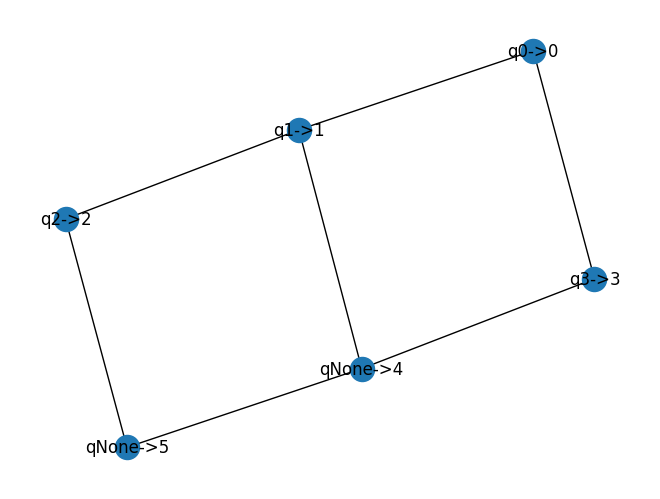

In [20]:
# @title
mapping = map_circuit(cuccaro, grid_hardware)
routed = route_circuit(cuccaro, grid_hardware, mapping)
display(cuccaro.draw(fold=-1))
display(routed.draw(fold=-1))
draw_mapping(grid_hardware, mapping)

In [21]:
# @title
# Do not delete this cell
def validate_routing(circuit, target_hardware, mapping, routed_circuit, check_unitary=True):
    '''Set check_unitary=False for circuits with over 10 qubits.'''
    # Check other arguments
    assert isinstance(circuit, QuantumCircuit)
    assert isinstance(target_hardware, nx.Graph)
    assert isinstance(mapping, dict)
    qubits = frozenset(q for q in circuit.qubits)
    assert len(circuit.qubits) == len(qubits), 'Unsupported: circuits with multiple registers'
    assert all(isinstance(q, Qubit) for q in qubits)
    assert len(qubits) <= len(target_hardware.nodes), 'Not enough qubits in the hardware'
    assert all(isinstance(hw_q, int) for hw_q in target_hardware.nodes), 'Unsupported: non-int hardware qubit ids'
    # Check unitary
    if check_unitary:  # Slow for circuits with more than 10 qubits
        extended_circuit = QuantumCircuit(len(target_hardware.nodes))
        for instr in circuit:
            extended_qubits = [extended_circuit.qubits[q._index]
                               for q in instr.qubits]
            extended_circuit.append(instr.operation, extended_qubits, instr.clbits)
        unmapped_circuit = QuantumCircuit(len(target_hardware.nodes))
        rev_mapping = {v: k._index for k, v in mapping.items()}
        for instr in routed_circuit:
            unmapped_qubits = [unmapped_circuit.qubits[rev_mapping.get(q._index, q._index)]
                               for q in instr.qubits]
            unmapped_circuit.append(instr.operation, unmapped_qubits, instr.clbits)

        from qiskit.quantum_info.operators.predicates import matrix_equal
        unitary = lambda c: qiskit.quantum_info.Operator(c).data
        assert matrix_equal(unitary(unmapped_circuit), unitary(extended_circuit)), (
            'Circuits are not eqivalent (for this test, make sure to include '
            'any unnessesary SWAP gates at the end of the circuit to ensure the '
            'qubits are moved back to their starting locations.)')
    # Check valid gates
    for instr in routed_circuit:
        if len(instr.qubits) < 2: continue  # Ignore single-qubit gates
        assert len(instr.qubits) <= 2, (
            f'Invalid gate {instr}: the routed circuit should not contain '
            f'3-qubit or larger gates')
        # Check connectivity of the two-qubit gate
        q1, q2 = instr.qubits
        assert (q1._index, q2._index) in target_hardware.edges, (
            f'Invalid gate {instr}: the routed circuit should not contain '
            f'two-qubits gates on pairs of non-adjacent qubits (in the '
            f'target_hardware graph)')

def score_routing(circuit, target_hardware, mapping, routed_circuit):
    '''
    Computes a score that counts the number of SWAPs needed for this routing.
    (Actually counts the number of extra CNOTs divided by 3.)

    Returns the tuple (your score, swap-there-and-back score).  Lower values are better.

    *This should be equal (or maybe a bit lower) than your score for part 1.*
    '''
    validate_routing(circuit, target_hardware, mapping, routed_circuit, check_unitary=False)

    def count_cnots_in_circuit(c):
        pm = qiskit.transpiler.PassManager([
                qiskit.transpiler.passes.BasisTranslator(qiskit.circuit.equivalence_library.SessionEquivalenceLibrary, ['u3', 'cx'])
            ])
        c2 = pm.run(c)
        count = sum(isinstance(instr.operation, qiskit.circuit.library.standard_gates.x.CXGate)
                    for instr in c2)
        return count

    old_cnot_count = count_cnots_in_circuit(circuit)
    new_cnot_count = count_cnots_in_circuit(routed_circuit)
    score = round((new_cnot_count - old_cnot_count) / 3, 3)
    if score == int(score): score = int(score)
    assert score >= 0, 'The schedule does not contain enough gates.'

    # Calculate target score assuming swap-there-and-back routing
    ig = interaction_graph_from_circuit(circuit)
    shortest_paths = dict(nx.all_pairs_shortest_path_length(target_hardware))
    target_score = 0
    for q1, q2 in ig.edges:
        hw_q1 = mapping[q1]
        hw_q2 = mapping[q2]
        dist = shortest_paths[hw_q1][hw_q2]
        cnot_count = ig[q1][q2]['weight']
        target_score += (dist-1) * 2 * cnot_count
    print(f'Your routing score is {score} SWAPs.')
    print(f'(You should have gotten {target_score} SWAPs if you used the '
          f'swap-there-and-back routing strategy.)')
    return score, target_score

In [22]:
# @title
# You may modify this cell to test scores for your mapper on various circuits

mapping = map_circuit(cuccaro, grid_hardware)
routed = route_circuit(cuccaro, grid_hardware, mapping)
score_routing(cuccaro, grid_hardware, mapping, routed)

Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 1 and 2 circuit qubits are used. Hardware qubits: 1 and 2 are adjacent
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 1 and 0 circuit qubits are used. Hardware qubits: 1 and 0 are adjacent
Instruction(name='h', num_qubits=1, num_clbits=0, params=[])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 2 and 1 circuit qubits are used. Hardware qubits: 2 and 1 are adjacent
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-0.7853981633974483])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 0 and 1 circuit qubits are used. Hardware qubits: 0 and 1 are adjacent
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.7853981633974483])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 2 and 1

AssertionError: Invalid gate CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(6, "q"), index=3>, <Qubit register=(6, "q"), index=2>), clbits=()): the routed circuit should not contain two-qubits gates on pairs of non-adjacent qubits (in the target_hardware graph)

In [23]:
def printMatrix(matrix):
  rowCount = 0
  column = 0
  for row in matrix:
    column = 0
    for cell in row:
      print(int(cell.real), end="")
      column+=1
    print()
    rowCount+=1


In [24]:
####GV Cell
# @title
# Do not delete this cell
def checkIfAdjacentNodes(node1, node2, target_hardware):
  if node1 in target_hardware.nodes and node2 in target_hardware.nodes:
    if target_hardware.has_edge(node1, node2):
      return True
  return False

def findAdjacentNodes(node, target_hardware):
  adjNode = []
  for edge in target_hardware.edges:
    if node in edge:
      if edge[0] == node:
        adjNode.append(edge[1])
  return adjNode

def route_circuit_gv(quantum_circuit:QuantumCircuit, target_hardware:nx.Graph,
                  mapping:Dict[Qubit, int]) -> QuantumCircuit:

    new_circuit = QuantumCircuit(len(target_hardware.nodes)-1)
    for instr in quantum_circuit:
      print(instr.operation)

      if len(instr.qubits) == 1:
        circuit_qubit_list = instr.qubits
        print("Single Qubits:", circuit_qubit_list[0]._index, "circuit qubit is used")
        hardware_qubit_id = mapping[circuit_qubit_list[0]]
        #print(hardware_qubit_id)
        new_circuit.append(instr.operation, [circuit_qubit_list[0]._index], instr.clbits)
      elif len(instr.qubits) == 2:
        circuit_qubit_list = instr.qubits
        print("Two Qubits:", circuit_qubit_list[0]._index, "and", circuit_qubit_list[1]._index, "circuit qubits are used. ", end="")
        hardware_qubit1_id = mapping[circuit_qubit_list[0]]
        hardware_qubit2_id = mapping[circuit_qubit_list[1]]
        checkIsAdjacent = checkIfAdjacentNodes(circuit_qubit_list[0]._index, circuit_qubit_list[1]._index, target_hardware)
        if not checkIsAdjacent:
          ## Add Swap there
          print("Hardware qubits:",hardware_qubit1_id, "and", hardware_qubit2_id, "are not an adjacent and do SWAP")
          #print("Add Swap there")
          #adjacentNode = findAdjacentNodes(circuit_qubit_list[0]._index,target_hardware)
          adjacentNode = findAdjacentNodes(hardware_qubit1_id,target_hardware)
          # new_circuit.swap(circuit_qubit_list[0]._index,circuit_qubit_list[1]._index)
          # new_circuit.append(instr.operation, [circuit_qubit_list[0]._index, circuit_qubit_list[1]._index], instr.clbits)
          new_circuit.swap(adjacentNode,circuit_qubit_list[1]._index)
          new_circuit.append(instr.operation, [circuit_qubit_list[0]._index,adjacentNode[0]], instr.clbits)
          new_circuit.swap(adjacentNode,circuit_qubit_list[1]._index)
          ## Add Swap back
          #print("Add Swap back")
        elif checkIsAdjacent:
          print("Hardware qubits:",hardware_qubit1_id, "and", hardware_qubit2_id, "are adjacent")
          new_circuit.append(instr.operation, [circuit_qubit_list[0]._index, circuit_qubit_list[1]._index], instr.clbits)
    return new_circuit
def validate_routing_gv(circuit, target_hardware, mapping, routed_circuit, check_unitary=True):
    '''Set check_unitary=False for circuits with over 10 qubits.'''
    # Check other arguments
    assert isinstance(circuit, QuantumCircuit)
    assert isinstance(target_hardware, nx.Graph)
    assert isinstance(mapping, dict)
    qubits = frozenset(q for q in circuit.qubits)
    assert len(circuit.qubits) == len(qubits), 'Unsupported: circuits with multiple registers'
    assert all(isinstance(q, Qubit) for q in qubits)
    assert len(qubits) <= len(target_hardware.nodes), 'Not enough qubits in the hardware'
    assert all(isinstance(hw_q, int) for hw_q in target_hardware.nodes), 'Unsupported: non-int hardware qubit ids'
    # Check unitary
    if check_unitary:  # Slow for circuits with more than 10 qubits
        extended_circuit = QuantumCircuit(len(target_hardware.nodes))
        for instr in circuit:
            extended_qubits = [extended_circuit.qubits[q._index]
                               for q in instr.qubits]
            extended_circuit.append(instr.operation, extended_qubits, instr.clbits)
        unmapped_circuit = QuantumCircuit(len(target_hardware.nodes))
        rev_mapping = {v: k._index for k, v in mapping.items()}
        print(1)
        print(rev_mapping)
        print(2)
        for instr in routed_circuit:
            print(instr)
            unmapped_qubits = [unmapped_circuit.qubits[rev_mapping.get(q._index, q._index)]
                               for q in instr.qubits]
            print(unmapped_qubits)
            unmapped_circuit.append(instr.operation, unmapped_qubits, instr.clbits)

        from qiskit.quantum_info.operators.predicates import matrix_equal
        unitary = lambda c: qiskit.quantum_info.Operator(c).data

        print("unmapped")
        display(unmapped_circuit.draw(fold=-1))
        print("extended")
        display(extended_circuit.draw(fold=-1))
        #print(unitary(unmapped_circuit), unitary(extended_circuit))

        # printMatrix(unitary(unmapped_circuit))
        # printMatrix(unitary(extended_circuit))
        assert matrix_equal(unitary(unmapped_circuit), unitary(extended_circuit)), (
            'Circuits are not eqivalent (for this test, make sure to include '
            'any unnessesary SWAP gates at the end of the circuit to ensure the '
            'qubits are moved back to their starting locations.)')
    # Check valid gates
    print("validation starts for gates")
    for edge in target_hardware.edges:
        print(edge)
    for instr in routed_circuit:
        print(instr)
        if len(instr.qubits) < 2: continue  # Ignore single-qubit gates
        assert len(instr.qubits) <= 2, (
            f'Invalid gate {instr}: the routed circuit should not contain '
            f'3-qubit or larger gates')
        # Check connectivity of the two-qubit gate
        q1, q2 = instr.qubits
        assert (q1._index, q2._index) in target_hardware.edges, (
            f'Invalid gate {instr}: the routed circuit should not contain '
            f'two-qubits gates on pairs of non-adjacent qubits (in the '
            f'target_hardware graph)')

def score_routing_gv(circuit, target_hardware, mapping, routed_circuit):
    '''
    Computes a score that counts the number of SWAPs needed for this routing.
    (Actually counts the number of extra CNOTs divided by 3.)

    Returns the tuple (your score, swap-there-and-back score).  Lower values are better.

    *This should be equal (or maybe a bit lower) than your score for part 1.*
    '''
    validate_routing_gv(circuit, target_hardware, mapping, routed_circuit, check_unitary=False)

    def count_cnots_in_circuit(c):
        pm = qiskit.transpiler.PassManager([
                qiskit.transpiler.passes.BasisTranslator(qiskit.circuit.equivalence_library.SessionEquivalenceLibrary, ['u3', 'cx'])
            ])
        c2 = pm.run(c)
        count = sum(isinstance(instr.operation, qiskit.circuit.library.standard_gates.x.CXGate)
                    for instr in c2)
        return count

    old_cnot_count = count_cnots_in_circuit(circuit)
    new_cnot_count = count_cnots_in_circuit(routed_circuit)
    score = round((new_cnot_count - old_cnot_count) / 3, 3)
    if score == int(score): score = int(score)
    assert score >= 0, 'The schedule does not contain enough gates.'

    # Calculate target score assuming swap-there-and-back routing
    ig = interaction_graph_from_circuit(circuit)
    shortest_paths = dict(nx.all_pairs_shortest_path_length(target_hardware))
    target_score = 0
    for q1, q2 in ig.edges:
        hw_q1 = mapping[q1]
        hw_q2 = mapping[q2]
        dist = shortest_paths[hw_q1][hw_q2]
        cnot_count = ig[q1][q2]['weight']
        target_score += (dist-1) * 2 * cnot_count
    print(f'Your routing score is {score} SWAPs.')
    print(f'(You should have gotten {target_score} SWAPs if you used the '
          f'swap-there-and-back routing strategy.)')
    return score, target_score

In [ ]:
# GV Cell for testing 1 CNOT mappings
def test1Cnot():
  _hardware1 = nx.path_graph(3)
  _cuccaro61 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[2];\ncx q[0],q[1];\n')
  _mapping1 = {Qubit(QuantumRegister(2, 'q'), 0): 0,
              Qubit(QuantumRegister(2, 'q'), 1): 2}
  _routing1 = route_circuit_gv(_cuccaro61, _hardware1, _mapping1)  # Run your code
  display(_cuccaro61.draw(fold=-1))
  display(_routing1.draw(fold=-1))
  draw_mapping(_hardware1, _mapping1)
  validate_routing_gv(_cuccaro61, _hardware1, _mapping1, _routing1)
  score_routing(_cuccaro61, _hardware1, _mapping1, _routing1)
  print('PASS: Valid circuit routing')
test1Cnot()

In [ ]:
# GV Cell
def test1():
  _hardware1 = nx.path_graph(4)
  _cuccaro61 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\ncx q[0],q[2];\ncx q[0],q[1];\n')
  _mapping1 = {Qubit(QuantumRegister(3, 'q'), 1): 0,
              Qubit(QuantumRegister(3, 'q'), 2): 1,
              Qubit(QuantumRegister(3, 'q'), 0): 2}
  _routing1 = route_circuit_gv(_cuccaro61, _hardware1, _mapping1)  # Run your code
  display(_cuccaro61.draw(fold=-1))
  display(_routing1.draw(fold=-1))
  draw_mapping(_hardware1, _mapping1)
  validate_routing_gv(_cuccaro61, _hardware1, _mapping1, _routing1)
  score_routing(_cuccaro61, _hardware1, _mapping1, _routing1)
  print('PASS: Valid circuit routing')

def test2():
  _hardware1 = nx.path_graph(4)
  _cuccaro61 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\ncx q[0],q[2];\ncx q[0],q[1];\n')
  _mapping1 = {Qubit(QuantumRegister(3, 'q'), 0): 0,
              Qubit(QuantumRegister(3, 'q'), 2): 1,
              Qubit(QuantumRegister(3, 'q'), 1): 2}
  _routing1 = route_circuit_gv(_cuccaro61, _hardware1, _mapping1)  # Run your code
  display(_cuccaro61.draw(fold=-1))
  display(_routing1.draw(fold=-1))
  draw_mapping(_hardware1, _mapping1)
  validate_routing_gv(_cuccaro61, _hardware1, _mapping1, _routing1)
  score_routing(_cuccaro61, _hardware1, _mapping1, _routing1)
  print('PASS: Valid circuit routing')
#test1()
test2()

In [ ]:
# GV Cell
# Do not delete this cell
# The autograder will test the function route_circuit.
# This test is worth most of the points for part 2
_hardware1 = nx.path_graph(4)
#_cuccaro6 = decomposed_adder_circuit(6)
_cuccaro61 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\ncx q[0],q[2];\ncx q[0],q[1];\n')
# Give a fixed mapping so we only test your router
# _mapping1 = {Qubit(QuantumRegister(6, 'q'), 1): 0,
#             Qubit(QuantumRegister(6, 'q'), 3): 1,
#             Qubit(QuantumRegister(6, 'q'), 0): 2,
#             Qubit(QuantumRegister(6, 'q'), 2): 3,
#             Qubit(QuantumRegister(6, 'q'), 4): 4,
#             Qubit(QuantumRegister(6, 'q'), 5): 5}
_mapping1 = {Qubit(QuantumRegister(3, 'q'), 0): 0,
            Qubit(QuantumRegister(3, 'q'), 2): 1,
            Qubit(QuantumRegister(3, 'q'), 1): 2}
#validate_mapping(_cuccaro6, _hardware, _mapping)
_routing1 = route_circuit_gv(_cuccaro61, _hardware1, _mapping1)  # Run your code
display(_cuccaro61.draw(fold=-1))
display(_routing1.draw(fold=-1))
draw_mapping(_hardware1, _mapping1)
validate_routing_gv(_cuccaro61, _hardware1, _mapping1, _routing1)
score_routing(_cuccaro61, _hardware1, _mapping1, _routing1)
print('PASS: Valid circuit routing')

In [ ]:
# GV Cell
# Do not delete this cell
# The autograder will test the function route_circuit.
# This test is worth most of the points for part 2
_hardware = nx.path_graph(7)
#_cuccaro6 = decomposed_adder_circuit(6)
_cuccaro6 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\ncx q[0],q[2];\ncx q[0],q[1];\nh q[1];\ncx q[3],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[3],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[3];\ncx q[0],q[3];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\ncx q[0],q[3];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[0],q[3];\ncx q[2],q[4];\ncx q[2],q[1];\nh q[2];\ncx q[4],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[4],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[4];\ncx q[1],q[4];\nrz(pi/4) q[1];\nrz(-pi/4) q[4];\ncx q[1],q[4];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[1],q[4];\ncx q[2],q[5];\nh q[2];\ncx q[4],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[4],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[4];\ncx q[1],q[4];\nrz(pi/4) q[1];\nrz(-pi/4) q[4];\ncx q[1],q[4];\ncx q[2],q[1];\nh q[1];\ncx q[3],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[3],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[3];\ncx q[0],q[3];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\ncx q[0],q[3];\ncx q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[1],q[3];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[2],q[4];\n')
# Give a fixed mapping so we only test your router
_mapping = {Qubit(QuantumRegister(6, 'q'), 1): 0,
            Qubit(QuantumRegister(6, 'q'), 3): 1,
            Qubit(QuantumRegister(6, 'q'), 0): 2,
            Qubit(QuantumRegister(6, 'q'), 2): 3,
            Qubit(QuantumRegister(6, 'q'), 4): 4,
            Qubit(QuantumRegister(6, 'q'), 5): 5}
validate_mapping(_cuccaro6, _hardware, _mapping)
_routing = route_circuit(_cuccaro6, _hardware, _mapping)  # Run your code
display(_cuccaro6.draw(fold=-1))
display(_routing.draw(fold=-1))
draw_mapping(_hardware, _mapping)
validate_routing(_cuccaro6, _hardware, _mapping, _routing)
#score_routing(_cuccaro6, _hardware, _mapping, _routing)
print('PASS: Valid circuit routing')

In [25]:
# Do not delete this cell
# The autograder will test the function route_circuit.
# This test is worth most of the points for part 2
_hardware = nx.path_graph(7)
#_cuccaro6 = decomposed_adder_circuit(6)
_cuccaro6 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[6];\ncx q[1],q[3];\ncx q[1],q[0];\nh q[1];\ncx q[3],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[3],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[3];\ncx q[0],q[3];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\ncx q[0],q[3];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[0],q[3];\ncx q[2],q[4];\ncx q[2],q[1];\nh q[2];\ncx q[4],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[4],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[4];\ncx q[1],q[4];\nrz(pi/4) q[1];\nrz(-pi/4) q[4];\ncx q[1],q[4];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[1],q[4];\ncx q[2],q[5];\nh q[2];\ncx q[4],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[4],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[4];\ncx q[1],q[4];\nrz(pi/4) q[1];\nrz(-pi/4) q[4];\ncx q[1],q[4];\ncx q[2],q[1];\nh q[1];\ncx q[3],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[3],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[3];\ncx q[0],q[3];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\ncx q[0],q[3];\ncx q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\ncx q[1],q[3];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[2],q[4];\n')
# Give a fixed mapping so we only test your router
_mapping = {Qubit(QuantumRegister(6, 'q'), 1): 0,
            Qubit(QuantumRegister(6, 'q'), 3): 1,
            Qubit(QuantumRegister(6, 'q'), 0): 2,
            Qubit(QuantumRegister(6, 'q'), 2): 3,
            Qubit(QuantumRegister(6, 'q'), 4): 4,
            Qubit(QuantumRegister(6, 'q'), 5): 5}
validate_mapping(_cuccaro6, _hardware, _mapping)
_routing = route_circuit(_cuccaro6, _hardware, _mapping)  # Run your code
validate_routing(_cuccaro6, _hardware, _mapping, _routing)
score_routing(_cuccaro6, _hardware, _mapping, _routing)
print('PASS: Valid circuit routing')

Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 1 and 3 circuit qubits are used. Hardware qubits: 0 and 1 are adjacent
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 1 and 0 circuit qubits are used. Hardware qubits: 0 and 2 are not an adjacent and do SWAP
Instruction(name='h', num_qubits=1, num_clbits=0, params=[])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 3 and 1 circuit qubits are used. Hardware qubits: 1 and 0 are adjacent
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-0.7853981633974483])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 0 and 1 circuit qubits are used. Hardware qubits: 2 and 0 are not an adjacent and do SWAP
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.7853981633974483])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_cl

In [ ]:
# Do not delete this cell
# The autograder will test the function route_circuit.
_hardware = nx.grid_2d_graph(6, 7)
_hardware = nx.relabel_nodes(_hardware,
    {n: i for i, n in enumerate(_hardware.nodes)})
#_cuccaro38 = decomposed_adder_circuit(38)
_cuccaro38 = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[38];\ncx q[1],q[19];\ncx q[1],q[0];\nh q[1];\ncx q[19],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[19],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[19];\ncx q[0],q[19];\nrz(pi/4) q[0];\nrz(-pi/4) q[19];\ncx q[0],q[19];\nrz(2.6375741) q[19];\nrx(pi) q[19];\nrz(2.6375741) q[19];\ncx q[0],q[19];\ncx q[2],q[20];\ncx q[2],q[1];\nh q[2];\ncx q[20],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[20],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[20];\ncx q[1],q[20];\nrz(pi/4) q[1];\nrz(-pi/4) q[20];\ncx q[1],q[20];\nrz(2.6375741) q[20];\nrx(pi) q[20];\nrz(2.6375741) q[20];\ncx q[1],q[20];\ncx q[3],q[21];\ncx q[3],q[2];\nh q[3];\ncx q[21],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[21],q[3];\nrz(pi/4) q[21];\nrz(-pi/4) q[3];\ncx q[2],q[3];\ncx q[2],q[21];\nrz(pi/4) q[2];\nrz(-pi/4) q[21];\ncx q[2],q[21];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\ncx q[2],q[21];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\ncx q[4],q[22];\ncx q[4],q[3];\nh q[4];\ncx q[22],q[4];\nrz(-pi/4) q[4];\ncx q[3],q[4];\nrz(pi/4) q[4];\ncx q[22],q[4];\nrz(pi/4) q[22];\nrz(-pi/4) q[4];\ncx q[3],q[4];\ncx q[3],q[22];\nrz(-pi/4) q[22];\nrz(pi/4) q[3];\ncx q[3],q[22];\nrz(2.6375741) q[22];\nrx(pi) q[22];\nrz(2.6375741) q[22];\ncx q[3],q[22];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\ncx q[5],q[23];\ncx q[5],q[4];\nh q[5];\ncx q[23],q[5];\nrz(-pi/4) q[5];\ncx q[4],q[5];\nrz(pi/4) q[5];\ncx q[23],q[5];\nrz(pi/4) q[23];\nrz(-pi/4) q[5];\ncx q[4],q[5];\ncx q[4],q[23];\nrz(-pi/4) q[23];\nrz(pi/4) q[4];\ncx q[4],q[23];\nrz(2.6375741) q[23];\nrx(pi) q[23];\nrz(2.6375741) q[23];\ncx q[4],q[23];\nrz(-5*pi/4) q[5];\nrx(pi/2) q[5];\nrz(pi/2) q[5];\ncx q[6],q[24];\ncx q[6],q[5];\nh q[6];\ncx q[24],q[6];\nrz(-pi/4) q[6];\ncx q[5],q[6];\nrz(pi/4) q[6];\ncx q[24],q[6];\nrz(pi/4) q[24];\nrz(-pi/4) q[6];\ncx q[5],q[6];\ncx q[5],q[24];\nrz(-pi/4) q[24];\nrz(pi/4) q[5];\ncx q[5],q[24];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\ncx q[5],q[24];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\ncx q[7],q[25];\ncx q[7],q[6];\nh q[7];\ncx q[25],q[7];\nrz(-pi/4) q[7];\ncx q[6],q[7];\nrz(pi/4) q[7];\ncx q[25],q[7];\nrz(pi/4) q[25];\nrz(-pi/4) q[7];\ncx q[6],q[7];\ncx q[6],q[25];\nrz(-pi/4) q[25];\nrz(pi/4) q[6];\ncx q[6],q[25];\nrz(2.6375741) q[25];\nrx(pi) q[25];\nrz(2.6375741) q[25];\ncx q[6],q[25];\nrz(-5*pi/4) q[7];\nrx(pi/2) q[7];\nrz(pi/2) q[7];\ncx q[8],q[26];\ncx q[8],q[7];\nh q[8];\ncx q[26],q[8];\nrz(-pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[8];\ncx q[26],q[8];\nrz(pi/4) q[26];\nrz(-pi/4) q[8];\ncx q[7],q[8];\ncx q[7],q[26];\nrz(-pi/4) q[26];\nrz(pi/4) q[7];\ncx q[7],q[26];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\ncx q[7],q[26];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[9],q[27];\ncx q[9],q[8];\nh q[9];\ncx q[27],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[27],q[9];\nrz(pi/4) q[27];\nrz(-pi/4) q[9];\ncx q[8],q[9];\ncx q[8],q[27];\nrz(-pi/4) q[27];\nrz(pi/4) q[8];\ncx q[8],q[27];\nrz(2.6375741) q[27];\nrx(pi) q[27];\nrz(2.6375741) q[27];\ncx q[8],q[27];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[10],q[28];\ncx q[10],q[9];\nh q[10];\ncx q[28],q[10];\nrz(-pi/4) q[10];\ncx q[9],q[10];\nrz(pi/4) q[10];\ncx q[28],q[10];\nrz(-pi/4) q[10];\nrz(pi/4) q[28];\ncx q[9],q[10];\nrz(-5*pi/4) q[10];\nrx(pi/2) q[10];\nrz(pi/2) q[10];\ncx q[9],q[28];\nrz(-pi/4) q[28];\nrz(pi/4) q[9];\ncx q[9],q[28];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\ncx q[9],q[28];\ncx q[11],q[29];\ncx q[11],q[10];\nh q[11];\ncx q[29],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(pi/4) q[11];\ncx q[29],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nrz(pi/4) q[29];\ncx q[10],q[29];\nrz(pi/4) q[10];\nrz(-pi/4) q[29];\ncx q[10],q[29];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\ncx q[10],q[29];\ncx q[12],q[30];\ncx q[12],q[11];\nh q[12];\ncx q[30],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(pi/4) q[12];\ncx q[30],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(-5*pi/4) q[12];\nrx(pi/2) q[12];\nrz(pi/2) q[12];\nrz(pi/4) q[30];\ncx q[11],q[30];\nrz(pi/4) q[11];\nrz(-pi/4) q[30];\ncx q[11],q[30];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[11],q[30];\ncx q[13],q[31];\ncx q[13],q[12];\nh q[13];\ncx q[31],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(pi/4) q[13];\ncx q[31],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[31];\ncx q[12],q[31];\nrz(pi/4) q[12];\nrz(-pi/4) q[31];\ncx q[12],q[31];\nrz(2.6375741) q[31];\nrx(pi) q[31];\nrz(2.6375741) q[31];\ncx q[12],q[31];\ncx q[14],q[32];\ncx q[14],q[13];\nh q[14];\ncx q[32],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(pi/4) q[14];\ncx q[32],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(-5*pi/4) q[14];\nrx(pi/2) q[14];\nrz(pi/2) q[14];\nrz(pi/4) q[32];\ncx q[13],q[32];\nrz(pi/4) q[13];\nrz(-pi/4) q[32];\ncx q[13],q[32];\nrz(2.6375741) q[32];\nrx(pi) q[32];\nrz(2.6375741) q[32];\ncx q[13],q[32];\ncx q[15],q[33];\ncx q[15],q[14];\nh q[15];\ncx q[33],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[15];\ncx q[33],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\nrz(pi/4) q[33];\ncx q[14],q[33];\nrz(pi/4) q[14];\nrz(-pi/4) q[33];\ncx q[14],q[33];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[14],q[33];\ncx q[16],q[34];\ncx q[16],q[15];\nh q[16];\ncx q[34],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[34],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\nrz(pi/4) q[34];\ncx q[15],q[34];\nrz(pi/4) q[15];\nrz(-pi/4) q[34];\ncx q[15],q[34];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\ncx q[15],q[34];\ncx q[17],q[35];\ncx q[17],q[16];\nh q[17];\ncx q[35],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(pi/4) q[17];\ncx q[35],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(-5*pi/4) q[17];\nrx(pi/2) q[17];\nrz(pi/2) q[17];\nrz(pi/4) q[35];\ncx q[16],q[35];\nrz(pi/4) q[16];\nrz(-pi/4) q[35];\ncx q[16],q[35];\nrz(2.6375741) q[35];\nrx(pi) q[35];\nrz(2.6375741) q[35];\ncx q[16],q[35];\ncx q[18],q[36];\ncx q[18],q[17];\nh q[18];\ncx q[36],q[18];\nrz(-pi/4) q[18];\ncx q[17],q[18];\nrz(pi/4) q[18];\ncx q[36],q[18];\nrz(-pi/4) q[18];\ncx q[17],q[18];\nrz(-5*pi/4) q[18];\nrx(pi/2) q[18];\nrz(pi/2) q[18];\nrz(pi/4) q[36];\ncx q[17],q[36];\nrz(pi/4) q[17];\nrz(-pi/4) q[36];\ncx q[17],q[36];\nrz(2.6375741) q[36];\nrx(pi) q[36];\nrz(2.6375741) q[36];\ncx q[17],q[36];\ncx q[18],q[37];\nh q[18];\ncx q[36],q[18];\nrz(-pi/4) q[18];\ncx q[17],q[18];\nrz(pi/4) q[18];\ncx q[36],q[18];\nrz(-pi/4) q[18];\ncx q[17],q[18];\nrz(-5*pi/4) q[18];\nrx(pi/2) q[18];\nrz(pi/2) q[18];\nrz(pi/4) q[36];\ncx q[17],q[36];\nrz(pi/4) q[17];\nrz(-pi/4) q[36];\ncx q[17],q[36];\ncx q[18],q[17];\nh q[17];\ncx q[35],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(pi/4) q[17];\ncx q[35],q[17];\nrz(-pi/4) q[17];\ncx q[16],q[17];\nrz(-5*pi/4) q[17];\nrx(pi/2) q[17];\nrz(pi/2) q[17];\nrz(pi/4) q[35];\ncx q[16],q[35];\nrz(pi/4) q[16];\nrz(-pi/4) q[35];\ncx q[16],q[35];\ncx q[17],q[16];\nh q[16];\ncx q[34],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[34],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\nrz(pi/4) q[34];\ncx q[15],q[34];\nrz(pi/4) q[15];\nrz(-pi/4) q[34];\ncx q[15],q[34];\ncx q[16],q[15];\nh q[15];\ncx q[33],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[15];\ncx q[33],q[15];\nrz(-pi/4) q[15];\ncx q[14],q[15];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\nrz(pi/4) q[33];\ncx q[14],q[33];\nrz(pi/4) q[14];\nrz(-pi/4) q[33];\ncx q[14],q[33];\ncx q[15],q[14];\nh q[14];\ncx q[32],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(pi/4) q[14];\ncx q[32],q[14];\nrz(-pi/4) q[14];\ncx q[13],q[14];\nrz(-5*pi/4) q[14];\nrx(pi/2) q[14];\nrz(pi/2) q[14];\nrz(pi/4) q[32];\ncx q[13],q[32];\nrz(pi/4) q[13];\nrz(-pi/4) q[32];\ncx q[13],q[32];\ncx q[14],q[13];\nh q[13];\ncx q[31],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(pi/4) q[13];\ncx q[31],q[13];\nrz(-pi/4) q[13];\ncx q[12],q[13];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[31];\ncx q[12],q[31];\nrz(pi/4) q[12];\nrz(-pi/4) q[31];\ncx q[12],q[31];\ncx q[13],q[12];\nh q[12];\ncx q[30],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(pi/4) q[12];\ncx q[30],q[12];\nrz(-pi/4) q[12];\ncx q[11],q[12];\nrz(-5*pi/4) q[12];\nrx(pi/2) q[12];\nrz(pi/2) q[12];\nrz(pi/4) q[30];\ncx q[11],q[30];\nrz(pi/4) q[11];\nrz(-pi/4) q[30];\ncx q[11],q[30];\ncx q[12],q[11];\nh q[11];\ncx q[29],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(pi/4) q[11];\ncx q[29],q[11];\nrz(-pi/4) q[11];\ncx q[10],q[11];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nrz(pi/4) q[29];\ncx q[10],q[29];\nrz(pi/4) q[10];\nrz(-pi/4) q[29];\ncx q[10],q[29];\ncx q[11],q[10];\nh q[10];\ncx q[28],q[10];\nrz(-pi/4) q[10];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\ncx q[11],q[29];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[12],q[30];\nrz(2.6375741) q[31];\nrx(pi) q[31];\nrz(2.6375741) q[31];\ncx q[13],q[31];\nrz(2.6375741) q[32];\nrx(pi) q[32];\nrz(2.6375741) q[32];\ncx q[14],q[32];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[15],q[33];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\ncx q[16],q[34];\nrz(2.6375741) q[35];\nrx(pi) q[35];\nrz(2.6375741) q[35];\ncx q[17],q[35];\nrz(2.6375741) q[36];\nrx(pi) q[36];\nrz(2.6375741) q[36];\ncx q[18],q[36];\ncx q[9],q[10];\nrz(pi/4) q[10];\ncx q[28],q[10];\nrz(-pi/4) q[10];\nrz(pi/4) q[28];\ncx q[9],q[10];\nrz(-5*pi/4) q[10];\nrx(pi/2) q[10];\nrz(pi/2) q[10];\ncx q[9],q[28];\nrz(-pi/4) q[28];\nrz(pi/4) q[9];\ncx q[9],q[28];\ncx q[10],q[9];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\ncx q[10],q[28];\nh q[9];\ncx q[27],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[27],q[9];\nrz(pi/4) q[27];\nrz(-pi/4) q[9];\ncx q[8],q[9];\ncx q[8],q[27];\nrz(-pi/4) q[27];\nrz(pi/4) q[8];\ncx q[8],q[27];\nrz(2.6375741) q[27];\nrx(pi) q[27];\nrz(2.6375741) q[27];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[9],q[8];\nh q[8];\ncx q[26],q[8];\nrz(-pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[8];\ncx q[26],q[8];\nrz(pi/4) q[26];\nrz(-pi/4) q[8];\ncx q[7],q[8];\ncx q[7],q[26];\nrz(-pi/4) q[26];\nrz(pi/4) q[7];\ncx q[7],q[26];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[8],q[7];\nh q[7];\ncx q[25],q[7];\nrz(-pi/4) q[7];\ncx q[6],q[7];\nrz(pi/4) q[7];\ncx q[25],q[7];\nrz(pi/4) q[25];\nrz(-pi/4) q[7];\ncx q[6],q[7];\ncx q[6],q[25];\nrz(-pi/4) q[25];\nrz(pi/4) q[6];\ncx q[6],q[25];\nrz(2.6375741) q[25];\nrx(pi) q[25];\nrz(2.6375741) q[25];\nrz(-5*pi/4) q[7];\nrx(pi/2) q[7];\nrz(pi/2) q[7];\ncx q[7],q[6];\nh q[6];\ncx q[24],q[6];\nrz(-pi/4) q[6];\ncx q[5],q[6];\nrz(pi/4) q[6];\ncx q[24],q[6];\nrz(pi/4) q[24];\nrz(-pi/4) q[6];\ncx q[5],q[6];\ncx q[5],q[24];\nrz(-pi/4) q[24];\nrz(pi/4) q[5];\ncx q[5],q[24];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\ncx q[6],q[5];\nh q[5];\ncx q[23],q[5];\nrz(-pi/4) q[5];\ncx q[4],q[5];\nrz(pi/4) q[5];\ncx q[23],q[5];\nrz(pi/4) q[23];\nrz(-pi/4) q[5];\ncx q[4],q[5];\ncx q[4],q[23];\nrz(-pi/4) q[23];\nrz(pi/4) q[4];\ncx q[4],q[23];\nrz(2.6375741) q[23];\nrx(pi) q[23];\nrz(2.6375741) q[23];\nrz(-5*pi/4) q[5];\nrx(pi/2) q[5];\nrz(pi/2) q[5];\ncx q[5],q[4];\nh q[4];\ncx q[22],q[4];\nrz(-pi/4) q[4];\ncx q[3],q[4];\nrz(pi/4) q[4];\ncx q[22],q[4];\nrz(pi/4) q[22];\nrz(-pi/4) q[4];\ncx q[3],q[4];\ncx q[3],q[22];\nrz(-pi/4) q[22];\nrz(pi/4) q[3];\ncx q[3],q[22];\nrz(2.6375741) q[22];\nrx(pi) q[22];\nrz(2.6375741) q[22];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\ncx q[4],q[3];\nh q[3];\ncx q[21],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[21],q[3];\nrz(pi/4) q[21];\nrz(-pi/4) q[3];\ncx q[2],q[3];\ncx q[2],q[21];\nrz(pi/4) q[2];\nrz(-pi/4) q[21];\ncx q[2],q[21];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\ncx q[3],q[2];\nh q[2];\ncx q[20],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[20],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[20];\ncx q[1],q[20];\nrz(pi/4) q[1];\nrz(-pi/4) q[20];\ncx q[1],q[20];\ncx q[2],q[1];\nh q[1];\ncx q[19],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[19],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[19];\ncx q[0],q[19];\nrz(pi/4) q[0];\nrz(-pi/4) q[19];\ncx q[0],q[19];\ncx q[1],q[0];\nrz(2.6375741) q[19];\nrx(pi) q[19];\nrz(2.6375741) q[19];\ncx q[1],q[19];\nrz(2.6375741) q[20];\nrx(pi) q[20];\nrz(2.6375741) q[20];\ncx q[2],q[20];\ncx q[3],q[21];\ncx q[4],q[22];\ncx q[5],q[23];\ncx q[6],q[24];\ncx q[7],q[25];\ncx q[8],q[26];\ncx q[9],q[27];\n')
# Give a fixed mapping so we only test your router
_mapping = {Qubit(QuantumRegister(38, 'q'), 1): 0, Qubit(QuantumRegister(38, 'q'), 19): 1, Qubit(QuantumRegister(38, 'q'), 0): 7, Qubit(QuantumRegister(38, 'q'), 2): 2, Qubit(QuantumRegister(38, 'q'), 20): 3, Qubit(QuantumRegister(38, 'q'), 3): 9, Qubit(QuantumRegister(38, 'q'), 21): 8, Qubit(QuantumRegister(38, 'q'), 4): 10, Qubit(QuantumRegister(38, 'q'), 22): 11, Qubit(QuantumRegister(38, 'q'), 5): 17, Qubit(QuantumRegister(38, 'q'), 23): 16, Qubit(QuantumRegister(38, 'q'), 6): 18, Qubit(QuantumRegister(38, 'q'), 24): 19, Qubit(QuantumRegister(38, 'q'), 7): 25, Qubit(QuantumRegister(38, 'q'), 25): 24, Qubit(QuantumRegister(38, 'q'), 8): 26, Qubit(QuantumRegister(38, 'q'), 26): 27, Qubit(QuantumRegister(38, 'q'), 9): 33, Qubit(QuantumRegister(38, 'q'), 27): 32, Qubit(QuantumRegister(38, 'q'), 10): 34, Qubit(QuantumRegister(38, 'q'), 28): 41, Qubit(QuantumRegister(38, 'q'), 11): 20, Qubit(QuantumRegister(38, 'q'), 29): 13, Qubit(QuantumRegister(38, 'q'), 12): 6, Qubit(QuantumRegister(38, 'q'), 30): 5, Qubit(QuantumRegister(38, 'q'), 13): 4, Qubit(QuantumRegister(38, 'q'), 31): 12, Qubit(QuantumRegister(38, 'q'), 14): 15, Qubit(QuantumRegister(38, 'q'), 32): 14, Qubit(QuantumRegister(38, 'q'), 15): 22, Qubit(QuantumRegister(38, 'q'), 33): 21, Qubit(QuantumRegister(38, 'q'), 16): 23, Qubit(QuantumRegister(38, 'q'), 34): 30, Qubit(QuantumRegister(38, 'q'), 17): 29, Qubit(QuantumRegister(38, 'q'), 35): 28, Qubit(QuantumRegister(38, 'q'), 18): 36, Qubit(QuantumRegister(38, 'q'), 36): 35, Qubit(QuantumRegister(38, 'q'), 37): 37}
validate_mapping(_cuccaro38, _hardware, _mapping)
_routing = route_circuit(_cuccaro38, _hardware, _mapping)  # Run your code
validate_routing(_cuccaro38, _hardware, _mapping, _routing, check_unitary=False)
_score, _target = score_routing(_cuccaro38, _hardware, _mapping, _routing)
assert _target == 380, 'internal error'
assert _score <= 380, 'score is above 380, try improving the mapping by placing pairs of qubits with many CNOTs close together'
print('PASS: Score is under 380 (see if you can beat our solution of 380)')

In [ ]:
# Do not delete this cell
# The autograder will test the function route_circuit.
# Hidden tests

# 3. Scheduling Gates

Your final task is to schedule gates. Gates are quantum hardware typically have different execution times. We want to schedule our gates to minimize total execution time (a heursitic is fine). Write some code to determine appropriate start times for each gate given execution times for gates.

Make sure your code runs quickly.  Each test shouldn't run longer than a few seconds and 30 seconds will timeout the grader.

In [27]:
# For simplicity, assume all 1 qubit gates have the same execution duration
# Except, assume Z gates are free, i.e. take no time to execute
# but you should still schedule Z gates at the appropriate time between other gates

# here are some sample gate times.
sample_gate_times = {
    '1' : 10.0,
    'rz' : 0.0,  # Free
    'cx' : 100.0,
}

def schedule_circuit(routed_circuit:QuantumCircuit, gate_times:Dict[str, float]
                    ) -> Dict[GateWrapper, float]:
    '''
    This function should take an input program given as a qiskit.QuantumCircuit,
    This circuit should be routed already!

    You should return the start time for every gate in the circuit as a
    dictionary: {GateWrapper(...) : start_time}, where GateWrapper is our above
    implementation which wraps qiskit Gates.

    Hints:
        - It may be helpful to build a dependency graph weighted using these gate
        times and use nx.all_pairs_dijkstra_path_length.
        - Create the schedule keys out of qiskit gates with:
            GateWrapper(gate[0], gate[1], gate[2], label=i)  # Unique values of i
    '''
    ### YOUR SOLUTION IN THIS FUNCTION

    # Convert SWAP gates to 3 CNOT gates
    pm = qiskit.transpiler.PassManager([
        qiskit.transpiler.passes.BasisTranslator(qiskit.circuit.equivalence_library.SessionEquivalenceLibrary, ['rz', 'rx', 'h', 'u3', 'cx'])
        ])
    routed_circuit = pm.run(routed_circuit)

    # May be useful but not required
    dep_graph = build_program_dependency_graph(routed_circuit)

    # A dictionary of gate->start_time
    gate_start_times:Dict[GateWrapper, float] = {}

    # YOUR CODE HERE
    qubitUsage = {routed_circuit.qubits[i]:-1 for i in range(len(routed_circuit.qubits))}
    print("qubitUsage:",qubitUsage)
    print("Gate start times:",gate_start_times)
    i=0
    for instr in routed_circuit:
      print(instr)
      num_of_qubits = instr.operation.num_qubits
      if num_of_qubits == 1: ##single qubit
        if qubitUsage[instr.qubits[0]] == -1: ##no dependency
          gateWrapper = GateWrapper(instr.operation, instr.qubits, [], f'{i} - {instr.name}')
          start_time = 0
          gate_start_times[gateWrapper] = start_time
          qubitUsage[instr.qubits[0]] = start_time + gate_times.get(instr.name,gate_times['1'])
        elif qubitUsage[instr.qubits[0]] != -1: ##dependency
          gateWrapper = GateWrapper(instr.operation, instr.qubits, [], f'{i} - {instr.name}')
          start_time = qubitUsage[instr.qubits[0]]
          gate_start_times[gateWrapper] = start_time
          qubitUsage[instr.qubits[0]] = start_time + gate_times.get(instr.name,gate_times['1'])
      elif num_of_qubits == 2: ##two qubit
        if qubitUsage[instr.qubits[0]] == -1 and qubitUsage[instr.qubits[1]] == -1: ##no dependency
          gateWrapper = GateWrapper(instr.operation, instr.qubits, [], f'{i} - {instr.name}')
          start_time = 0
          gate_start_times[gateWrapper] = start_time
          qubitUsage[instr.qubits[0]] = start_time + gate_times.get(instr.name,gate_times['1'])
          qubitUsage[instr.qubits[1]] = start_time + gate_times.get(instr.name,gate_times['1'])
        else:#elif qubitUsage[instr.qubits[0]] != -1 and qubitUsage[instr.qubits[1]] != -1:
          gateWrapper = GateWrapper(instr.operation, instr.qubits, [], f'{i} - {instr.name}')
          start_time = max(qubitUsage[instr.qubits[0]], qubitUsage[instr.qubits[1]])
          gate_start_times[gateWrapper] = start_time
          qubitUsage[instr.qubits[0]] = start_time + gate_times.get(instr.name,gate_times['1'])
          qubitUsage[instr.qubits[1]] = start_time + gate_times.get(instr.name,gate_times['1'])
      i+=1

    print("Gate start times:",gate_start_times)
    return gate_start_times
    return gate_start_times

In [28]:
# You may modify this cell to test scores for your mapper on various circuits

mapping = map_circuit(cuccaro, grid_hardware)
routed = route_circuit(cuccaro, grid_hardware, mapping)
schedule = schedule_circuit(routed, sample_gate_times)
schedule

Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 1 and 2 circuit qubits are used. Hardware qubits: 1 and 2 are adjacent
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 1 and 0 circuit qubits are used. Hardware qubits: 1 and 0 are adjacent
Instruction(name='h', num_qubits=1, num_clbits=0, params=[])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 2 and 1 circuit qubits are used. Hardware qubits: 2 and 1 are adjacent
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-0.7853981633974483])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 0 and 1 circuit qubits are used. Hardware qubits: 0 and 1 are adjacent
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.7853981633974483])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 2 and 1

{0 - cx{cx(0,1)}: 0,
 1 - cx{cx(1,2)}: 100.0,
 2 - cx{cx(2,1)}: 200.0,
 3 - cx{cx(1,2)}: 300.0,
 4 - cx{cx(0,1)}: 400.0,
 5 - h{h(0)}: 500.0,
 6 - cx{cx(1,2)}: 500.0,
 7 - cx{cx(2,1)}: 600.0,
 8 - cx{cx(1,2)}: 700.0,
 9 - cx{cx(1,0)}: 800.0,
 10 - rz{rz(0)}: 900.0,
 11 - cx{cx(1,0)}: 900.0,
 12 - cx{cx(0,1)}: 1000.0,
 13 - cx{cx(1,0)}: 1100.0,
 14 - cx{cx(2,1)}: 1200.0,
 15 - cx{cx(1,0)}: 1300.0,
 16 - cx{cx(0,1)}: 1400.0,
 17 - cx{cx(1,0)}: 1500.0,
 18 - rz{rz(0)}: 1600.0,
 19 - cx{cx(1,0)}: 1600.0,
 20 - rz{rz(0)}: 1700.0,
 21 - cx{cx(1,0)}: 1700.0,
 22 - cx{cx(0,1)}: 1800.0,
 23 - cx{cx(1,0)}: 1900.0,
 24 - cx{cx(2,1)}: 2000.0,
 25 - cx{cx(1,0)}: 2100.0,
 26 - cx{cx(0,1)}: 2200.0,
 27 - cx{cx(1,0)}: 2300.0,
 28 - rz{rz(0)}: 2400.0,
 29 - rx{rx(0)}: 2400.0,
 30 - rz{rz(0)}: 2410.0,
 31 - rz{rz(1)}: 2400.0,
 32 - cx{cx(2,1)}: 2400.0,
 33 - rz{rz(1)}: 2500.0,
 34 - rz{rz(2)}: 2500.0,
 35 - cx{cx(2,1)}: 2500.0,
 36 - rz{rz(1)}: 2600.0,
 37 - rx{rx(1)}: 2600.0,
 38 - rz{rz(1)}: 2610.0,
 

In [29]:
# Do not modify this function
def schedule_to_circuit(schedule):
    qubits = set()
    for gate in schedule.keys():
        qubits.update(gate.qubits)
    n = len(qubits)
    circuit = QuantumCircuit(next(iter(qubits))._register)
    ordered = sorted(((time, gate)
                      for gate, time in schedule.items()),
                     key=lambda x:(x[0], x[1].gate.name!='rz'))
    for time, gate in ordered:
        new_qubits = [circuit.qubits[q._index] for q in gate.qubits]
        circuit.append(gate.gate, new_qubits, [])
    return circuit

# Make sure the schedule still represents the original circuit
schedule_to_circuit(schedule).draw(fold=-1)

┌───┐          ┌───┐┌──────────┐┌───┐     ┌───┐     ┌───┐     ┌───┐┌─────────┐┌───┐┌──────────┐┌───┐     ┌───┐     ┌───┐     ┌───┐┌───────────┐┌─────────┐┌─────────┐                                                ┌───┐     ┌───┐                                          ┌───┐     ┌───┐                                                                                                                                                                                                                                    ┌─────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              ┌─────────┐                                                                                                                     ┌───┐     ┌───┐                                                         ┌───┐     ┌───┐┌───┐┌───┐┌──────────┐┌───┐     ┌───┐     ┌───┐     ┌───┐┌─────────┐┌───┐┌──────────┐┌───┐     ┌───┐     ┌───┐     ┌───┐┌───────────┐┌─────────┐┌─────────┐                                                                                   
q_0: ──■───────────────────■──┤ H ├──────────┤ X ├┤ Rz(-π/4) ├┤ X ├──■──┤ X ├─────┤ X ├──■──┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├──■──┤ X ├─────┤ X ├──■──┤ X ├┤ Rz(-5π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├────────────────────────────────────────────────┤ X ├──■──┤ X ├──────────────────────────────────────────┤ X ├──■──┤ X ├─────────────────■────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ Rz(π/4) ├───────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■────────────────────────────────────────────────────────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────■──┤ Rz(π/4) ├───────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────┤ X ├──■──┤ X ├─────────────────────────────────────────────────────────┤ X ├──■──┤ X ├┤ H ├┤ X ├┤ Rz(-π/4) ├┤ X ├──■──┤ X ├─────┤ X ├──■──┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(-π/4) ├┤ X ├──■──┤ X ├─────┤ X ├──■──┤ X ├┤ Rz(-5π/4) ├┤ Rx(π/2) ├┤ Rz(π/2) ├───────────────────────■────────────────────────────────────────────────────────■──
     ┌─┴─┐     ┌───┐     ┌─┴─┐└───┘┌───┐     └─┬─┘└──────────┘└─┬─┘┌─┴─┐└─┬─┘┌───┐└─┬─┘┌─┴─┐└─┬─┘└─────────┘└─┬─┘└──────────┘└─┬─┘┌─┴─┐└─┬─┘┌───┐└─┬─┘┌─┴─┐└─┬─┘└┬─────────┬┘└──┬───┬──┘├─────────┴┐┌───┐┌────────────┐┌───────┐┌────────────┐┌───┐└─┬─┘┌─┴─┐└─┬─┘┌───┐     ┌───┐     ┌───┐        ┌───┐    └─┬─┘┌─┴─┐└─┬─┘     ┌───┐     ┌─┴─┐     ┌───┐                                                                    ┌───┐     ┌─┴─┐     ┌───┐                                                                                          ┌───┐     ┌─┴─┐└─────────┘┌───┐                                                                                  ┌───┐     ┌─┴─┐     ┌───┐                                                                                                           ┌───┐     ┌─┴─┐     ┌───┐                                                                    

In [30]:
# Do not delete this cell
def validate_schedule(routed_circuit, gate_times, schedule, check_unitary=True):
    '''Set check_unitary=False for circuits with over 10 qubits.'''
    # Check other arguments
    assert isinstance(routed_circuit, QuantumCircuit)
    assert isinstance(gate_times, dict)
    assert isinstance(schedule, dict)
    assert (len(routed_circuit.qubits)
            == len(frozenset(q._index for q in routed_circuit.qubits))), (
        'Unsupported: circuits with multiple registers')
    # Convert schedule back to a circuit
    s_circuit = schedule_to_circuit(schedule)
    r_qubits = frozenset(q for q in routed_circuit.qubits)
    s_qubits = frozenset(q for q in routed_circuit.qubits)
    assert r_qubits == s_qubits, 'schedule has different qubits than the circuit'
    # Check allowed gates
    for gate in schedule.keys():
        if len(gate.qubits) < 2: continue
        assert len(gate.qubits) <= 2, (
            'Only one- and two-qubit gates are allowed in the schedule')
        assert isinstance(gate.gate, qiskit.circuit.library.standard_gates.x.CXGate), (
            'Two-qubit gates other than CNOT are not allwed in the schedule')
    # Check for overlapping gates
    sorted_schedule = sorted(schedule.items(), key=lambda x:x[1])
    for i, (gate, time) in enumerate(sorted_schedule):
        end_time = time + gate_times.get(gate.gate.name, gate_times['1'])
        j = 0
        for j in range(i+1, len(sorted_schedule)):
            if sorted_schedule[j][1] >= end_time: break
        nearby_gates = sorted_schedule[i+1:j]
        left = max((
            t2 + gate_times.get(g2.gate.name, gate_times['1'])
            for g2, t2 in nearby_gates
            if (t2 + gate_times.get(g2.gate.name, gate_times['1']) < end_time
                and len(set(gate.qubits).intersection(g2.qubits)) > 0)
                and g2 != gate),
            default=0
        )
        right = min((
            t2
            for g2, t2 in nearby_gates
            if ((t2 > time or (
                    gate_times.get(g2.gate.name, gate_times['1']) != 0
                    and t2 >= time))
                and len(set(gate.qubits).intersection(g2.qubits)) > 0)
                and g2 != gate),
            default=float('inf')
        )
        #print(left, right)
        assert left <= time+1e-8 and right >= end_time-1e-8, (
            'At least one gate is scheduled during the same time on the same qubits '
            f'(at time {time} - {end_time}, gate={gate})')

    # Check unitary
    if check_unitary:  # Slow for circuits with more than 10 qubits
        from qiskit.quantum_info.operators.predicates import matrix_equal
        unitary = lambda c: qiskit.quantum_info.Operator(c).data
        assert matrix_equal(unitary(s_circuit), unitary(routed_circuit)), (
            'schedule is not equivalent to the input circuit')

def score_schedule(routed_circuit, gate_times, schedule):
    '''
    Computes the active qubit time of the schedule.

    Returns the tuple (your score, worst-case serial score).  Lower values are better.
    '''
    validate_schedule(routed_circuit, gate_times, schedule, check_unitary=False)

    total_duration = max((
        time + gate_times.get(gate.gate.name, gate_times['1'])
        for gate, time in schedule.items()),
        default=0
    )
    first_use_each_qubit = {
        q: min((time for gate, time in schedule.items()
                     if q in gate.qubits),
               default=total_duration)
        for q in routed_circuit.qubits
    }
    qubit_usage_times = {
        q: total_duration - first_use
        for q, first_use in first_use_each_qubit.items()
    }
    total_active = sum(qubit_usage_times.values())

    num_used_qubits = sum(t > 0 for t in qubit_usage_times.values())
    worst_serial_score = num_used_qubits * sum(
        gate_times.get(gate.gate.name, gate_times['1'])
        for gate in schedule.keys()
    )
    print(f'(Total circuit duration is {total_duration})')
    #print(f'Qubit active durations:\n{qubit_usage_times}')
    print(f'Your scheduling score is {total_active} ns, better than the worst '
          f'case score of {worst_serial_score}.')
    return total_active, worst_serial_score

In [31]:
# You may modify this cell to test scores for your mapper on various circuits

mapping = map_circuit(cuccaro, grid_hardware)
routed = route_circuit(cuccaro, grid_hardware, mapping)
schedule = schedule_circuit(routed, sample_gate_times)
display(schedule)
score_schedule(routed, sample_gate_times, schedule)

Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 1 and 2 circuit qubits are used. Hardware qubits: 1 and 2 are adjacent
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 1 and 0 circuit qubits are used. Hardware qubits: 1 and 0 are adjacent
Instruction(name='h', num_qubits=1, num_clbits=0, params=[])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 2 and 1 circuit qubits are used. Hardware qubits: 2 and 1 are adjacent
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-0.7853981633974483])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 0 and 1 circuit qubits are used. Hardware qubits: 0 and 1 are adjacent
Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.7853981633974483])
Single Qubits: 1 circuit qubit is used
Instruction(name='cx', num_qubits=2, num_clbits=0, params=[])
Two Qubits: 2 and 1

{0 - cx{cx(0,1)}: 0,
 1 - cx{cx(1,2)}: 100.0,
 2 - cx{cx(2,1)}: 200.0,
 3 - cx{cx(1,2)}: 300.0,
 4 - cx{cx(0,1)}: 400.0,
 5 - h{h(0)}: 500.0,
 6 - cx{cx(1,2)}: 500.0,
 7 - cx{cx(2,1)}: 600.0,
 8 - cx{cx(1,2)}: 700.0,
 9 - cx{cx(1,0)}: 800.0,
 10 - rz{rz(0)}: 900.0,
 11 - cx{cx(1,0)}: 900.0,
 12 - cx{cx(0,1)}: 1000.0,
 13 - cx{cx(1,0)}: 1100.0,
 14 - cx{cx(2,1)}: 1200.0,
 15 - cx{cx(1,0)}: 1300.0,
 16 - cx{cx(0,1)}: 1400.0,
 17 - cx{cx(1,0)}: 1500.0,
 18 - rz{rz(0)}: 1600.0,
 19 - cx{cx(1,0)}: 1600.0,
 20 - rz{rz(0)}: 1700.0,
 21 - cx{cx(1,0)}: 1700.0,
 22 - cx{cx(0,1)}: 1800.0,
 23 - cx{cx(1,0)}: 1900.0,
 24 - cx{cx(2,1)}: 2000.0,
 25 - cx{cx(1,0)}: 2100.0,
 26 - cx{cx(0,1)}: 2200.0,
 27 - cx{cx(1,0)}: 2300.0,
 28 - rz{rz(0)}: 2400.0,
 29 - rx{rx(0)}: 2400.0,
 30 - rz{rz(0)}: 2410.0,
 31 - rz{rz(1)}: 2400.0,
 32 - cx{cx(2,1)}: 2400.0,
 33 - rz{rz(1)}: 2500.0,
 34 - rz{rz(2)}: 2500.0,
 35 - cx{cx(2,1)}: 2500.0,
 36 - rz{rz(1)}: 2600.0,
 37 - rx{rx(1)}: 2600.0,
 38 - rz{rz(1)}: 2610.0,
 

(Total circuit duration is 22760.0)
Your scheduling score is 124330.0 ns, better than the worst case score of 144120.0.


(124330.0, 144120.0)

In [32]:
# Do not delete this cell
# The autograder will test the function schedule_circuit.
# This test is worth most of the points for part 1
# Give a fixed routing so we only test your scheduler
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[5];\ncx q[0],q[1];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\ncx q[2],q[1];\nrz(pi/4) q[2];\nrz(-pi/4) q[1];\ncx q[2],q[1];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[2],q[1];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\ncx q[2],q[1];\nrz(pi/4) q[2];\nrz(-pi/4) q[1];\ncx q[2],q[1];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
_schedule = schedule_circuit(_routed, _gate_times)
validate_schedule(_routed, _gate_times, _schedule)
score_schedule(_routed, _gate_times, _schedule)
print('PASS: Valid circuit schedule')

qubitUsage: {<Qubit register=(5, "q"), index=0>: -1, <Qubit register=(5, "q"), index=1>: -1, <Qubit register=(5, "q"), index=2>: -1, <Qubit register=(5, "q"), index=3>: -1, <Qubit register=(5, "q"), index=4>: -1}
Gate start times: {}
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(5, "q"), index=0>, <Qubit register=(5, "q"), index=1>), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=0>), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(5, "q"), index=0>, <Qubit register=(5, "q"), index=1>), clbits=())
CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(5, "q"), index=1>, <Qubit register=(5, "q"), index=0>), clbits=())
CircuitInstruction(operation=I

In [ ]:
# Do not delete this cell
# The autograder will test the function schedule_circuit.
# Give a fixed routing so we only test your scheduler
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[36];\ncx q[0],q[1];\ncx q[0],q[6];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\nrz(pi/4) q[6];\nrz(-pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(pi/4) q[3];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\ncx q[8],q[7];\ncx q[8],q[2];\nh q[8];\ncx q[7],q[8];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nrz(pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[7];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[7];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(2.6375741) q[7];\nrx(pi) q[7];\nrz(2.6375741) q[7];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[9],q[10];\ncx q[9],q[8];\nh q[9];\ncx q[10],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[10],q[9];\nrz(pi/4) q[10];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(-pi/4) q[10];\nrz(pi/4) q[8];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(2.6375741) q[10];\nrx(pi) q[10];\nrz(2.6375741) q[10];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[15],q[14];\ncx q[15],q[9];\nh q[15];\ncx q[14],q[15];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nrz(pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[14];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(-pi/4) q[14];\nrz(pi/4) q[9];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(2.6375741) q[14];\nrx(pi) q[14];\nrz(2.6375741) q[14];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\ncx q[16],q[17];\ncx q[16],q[15];\nh q[16];\ncx q[17],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[17],q[16];\nrz(pi/4) q[17];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(-pi/4) q[17];\nrz(pi/4) q[15];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(2.6375741) q[17];\nrx(pi) q[17];\nrz(2.6375741) q[17];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\ncx q[22],q[21];\ncx q[22],q[16];\nh q[22];\ncx q[21],q[22];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nrz(pi/4) q[22];\ncx q[21],q[22];\nrz(pi/4) q[21];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(-pi/4) q[21];\nrz(pi/4) q[16];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(-5*pi/4) q[22];\nrx(pi/2) q[22];\nrz(pi/2) q[22];\ncx q[23],q[29];\ncx q[23],q[22];\nh q[23];\ncx q[29],q[23];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nrz(pi/4) q[23];\ncx q[29],q[23];\nrz(pi/4) q[29];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(-pi/4) q[29];\nrz(pi/4) q[22];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(-5*pi/4) q[23];\nrx(pi/2) q[23];\nrz(pi/2) q[23];\ncx q[11],q[5];\nswap q[17],q[11];\ncx q[17],q[23];\nswap q[17],q[11];\nh q[11];\ncx q[5],q[11];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nrz(pi/4) q[11];\ncx q[5],q[11];\nrz(pi/4) q[5];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(-pi/4) q[5];\nrz(pi/4) q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nswap q[10],q[4];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[4];\nswap q[10],q[4];\ncx q[10],q[11];\nswap q[10],q[4];\nh q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(pi/4) q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nrz(pi/4) q[28];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nrz(-pi/4) q[28];\nrz(pi/4) q[11];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\ncx q[13],q[12];\nswap q[7],q[13];\nswap q[1],q[7];\nswap q[2],q[1];\nswap q[3],q[2];\ncx q[3],q[4];\nswap q[3],q[2];\nswap q[2],q[1];\nswap q[1],q[7];\nswap q[7],q[13];\nh q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(2.6375741) q[12];\nrx(pi) q[12];\nrz(2.6375741) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\ncx q[19],q[18];\ncx q[19],q[13];\nh q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(pi/4) q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(-5*pi/4) q[19];\nrx(pi/2) q[19];\nrz(pi/2) q[19];\nrz(pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\nrz(pi/4) q[13];\nrz(-pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\ncx q[20],q[26];\ncx q[20],q[19];\nh q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(pi/4) q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(-5*pi/4) q[20];\nrx(pi/2) q[20];\nrz(pi/2) q[20];\nrz(pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\nrz(pi/4) q[19];\nrz(-pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\ncx q[25],q[24];\nswap q[19],q[25];\ncx q[19],q[20];\nswap q[19],q[25];\nh q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(pi/4) q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(-5*pi/4) q[25];\nrx(pi/2) q[25];\nrz(pi/2) q[25];\nrz(pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nrz(pi/4) q[20];\nrz(-pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\ncx q[31],q[30];\ncx q[31],q[25];\nh q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(pi/4) q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(-5*pi/4) q[31];\nrx(pi/2) q[31];\nrz(pi/2) q[31];\nrz(pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\nrz(pi/4) q[25];\nrz(-pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\ncx q[32],q[33];\ncx q[32],q[31];\nh q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(pi/4) q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(-5*pi/4) q[32];\nrx(pi/2) q[32];\nrz(pi/2) q[32];\nrz(pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nrz(pi/4) q[31];\nrz(-pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nswap q[33],q[27];\ncx q[33],q[34];\nswap q[33],q[27];\nswap q[26],q[27];\ncx q[26],q[32];\nswap q[26],q[27];\nh q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(pi/4) q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(-5*pi/4) q[27];\nrx(pi/2) q[27];\nrz(pi/2) q[27];\nrz(pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nrz(pi/4) q[32];\nrz(-pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nswap q[33],q[27];\nswap q[34],q[33];\ncx q[34],q[35];\nswap q[34],q[33];\nswap q[33],q[27];\nh q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(pi/4) q[27];\nswap q[28],q[34];\ncx q[28],q[27];\nswap q[28],q[34];\nrz(-pi/4) q[27];\nswap q[26],q[32];\ncx q[26],q[27];\nswap q[26],q[32];\nrz(-5*pi/4) q[27];\nrx(pi/2) q[27];\nrz(pi/2) q[27];\nrz(pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nrz(pi/4) q[32];\nrz(-pi/4) q[34];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nswap q[26],q[27];\ncx q[26],q[32];\nswap q[26],q[27];\nh q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(pi/4) q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\ncx q[31],q[32];\nrz(-5*pi/4) q[32];\nrx(pi/2) q[32];\nrz(pi/2) q[32];\nrz(pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nrz(pi/4) q[31];\nrz(-pi/4) q[33];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\ncx q[32],q[31];\nh q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(pi/4) q[31];\ncx q[30],q[31];\nrz(-pi/4) q[31];\ncx q[25],q[31];\nrz(-5*pi/4) q[31];\nrx(pi/2) q[31];\nrz(pi/2) q[31];\nrz(pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\nrz(pi/4) q[25];\nrz(-pi/4) q[30];\nswap q[24],q[25];\ncx q[24],q[30];\nswap q[24],q[25];\ncx q[31],q[25];\nh q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(pi/4) q[25];\ncx q[24],q[25];\nrz(-pi/4) q[25];\nswap q[19],q[20];\ncx q[19],q[25];\nswap q[19],q[20];\nrz(-5*pi/4) q[25];\nrx(pi/2) q[25];\nrz(pi/2) q[25];\nrz(pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nrz(pi/4) q[20];\nrz(-pi/4) q[24];\nswap q[19],q[20];\nswap q[18],q[19];\ncx q[18],q[24];\nswap q[18],q[19];\nswap q[19],q[20];\nswap q[19],q[25];\ncx q[19],q[20];\nswap q[19],q[25];\nh q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(pi/4) q[20];\ncx q[26],q[20];\nrz(-pi/4) q[20];\ncx q[19],q[20];\nrz(-5*pi/4) q[20];\nrx(pi/2) q[20];\nrz(pi/2) q[20];\nrz(pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\nrz(pi/4) q[19];\nrz(-pi/4) q[26];\nswap q[25],q[19];\ncx q[25],q[26];\nswap q[25],q[19];\ncx q[20],q[19];\nh q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(pi/4) q[19];\ncx q[18],q[19];\nrz(-pi/4) q[19];\ncx q[13],q[19];\nrz(-5*pi/4) q[19];\nrx(pi/2) q[19];\nrz(pi/2) q[19];\nrz(pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\nrz(pi/4) q[13];\nrz(-pi/4) q[18];\nswap q[12],q[13];\ncx q[12],q[18];\nswap q[12],q[13];\ncx q[19],q[13];\nh q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[13];\ncx q[12],q[13];\nrz(-pi/4) q[13];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[7],q[1];\ncx q[7],q[13];\nswap q[7],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(-5*pi/4) q[13];\nrx(pi/2) q[13];\nrz(pi/2) q[13];\nrz(pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nrz(pi/4) q[4];\nrz(-pi/4) q[12];\nswap q[3],q[4];\nswap q[2],q[3];\nswap q[1],q[2];\nswap q[0],q[1];\nswap q[6],q[0];\ncx q[6],q[12];\nswap q[6],q[0];\nswap q[0],q[1];\nswap q[1],q[2];\nswap q[2],q[3];\nswap q[3],q[4];\nswap q[7],q[13];\nswap q[1],q[7];\nswap q[2],q[1];\nswap q[3],q[2];\ncx q[3],q[4];\nswap q[3],q[2];\nswap q[2],q[1];\nswap q[1],q[7];\nswap q[7],q[13];\nh q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nrz(2.6375741) q[12];\nrx(pi) q[12];\nrz(2.6375741) q[12];\ncx q[13],q[12];\nrz(2.6375741) q[18];\nrx(pi) q[18];\nrz(2.6375741) q[18];\ncx q[19],q[18];\nrz(2.6375741) q[26];\nrx(pi) q[26];\nrz(2.6375741) q[26];\ncx q[20],q[26];\nrz(2.6375741) q[24];\nrx(pi) q[24];\nrz(2.6375741) q[24];\ncx q[25],q[24];\nrz(2.6375741) q[30];\nrx(pi) q[30];\nrz(2.6375741) q[30];\ncx q[31],q[30];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[32],q[33];\nrz(2.6375741) q[34];\nrx(pi) q[34];\nrz(2.6375741) q[34];\nswap q[33],q[27];\ncx q[33],q[34];\nswap q[33],q[27];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(pi/4) q[4];\nswap q[22],q[28];\nswap q[16],q[22];\nswap q[10],q[16];\ncx q[10],q[4];\nswap q[10],q[16];\nswap q[16],q[22];\nswap q[22],q[28];\nrz(-pi/4) q[4];\nrz(pi/4) q[28];\nswap q[5],q[11];\ncx q[5],q[4];\nswap q[5],q[11];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nrz(-pi/4) q[28];\nrz(pi/4) q[11];\nswap q[10],q[11];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[11];\nswap q[10],q[4];\ncx q[10],q[11];\nswap q[10],q[4];\nrz(2.6375741) q[28];\nrx(pi) q[28];\nrz(2.6375741) q[28];\nswap q[10],q[4];\nswap q[16],q[10];\nswap q[22],q[16];\ncx q[22],q[28];\nswap q[22],q[16];\nswap q[16],q[10];\nswap q[10],q[4];\nh q[11];\ncx q[5],q[11];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nrz(pi/4) q[11];\ncx q[5],q[11];\nrz(pi/4) q[5];\nrz(-pi/4) q[11];\nswap q[17],q[23];\ncx q[17],q[11];\nswap q[17],q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(-pi/4) q[5];\nrz(pi/4) q[23];\nswap q[17],q[23];\nswap q[11],q[17];\ncx q[11],q[5];\nswap q[11],q[17];\nswap q[17],q[23];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nrz(-5*pi/4) q[11];\nrx(pi/2) q[11];\nrz(pi/2) q[11];\nswap q[17],q[11];\ncx q[17],q[23];\nswap q[17],q[11];\nh q[23];\ncx q[29],q[23];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nrz(pi/4) q[23];\ncx q[29],q[23];\nrz(pi/4) q[29];\nrz(-pi/4) q[23];\ncx q[22],q[23];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(-pi/4) q[29];\nrz(pi/4) q[22];\nswap q[28],q[22];\ncx q[28],q[29];\nswap q[28],q[22];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\nrz(-5*pi/4) q[23];\nrx(pi/2) q[23];\nrz(pi/2) q[23];\ncx q[23],q[22];\nh q[22];\ncx q[21],q[22];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nrz(pi/4) q[22];\ncx q[21],q[22];\nrz(pi/4) q[21];\nrz(-pi/4) q[22];\ncx q[16],q[22];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(-pi/4) q[21];\nrz(pi/4) q[16];\nswap q[15],q[16];\ncx q[15],q[21];\nswap q[15],q[16];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nrz(-5*pi/4) q[22];\nrx(pi/2) q[22];\nrz(pi/2) q[22];\ncx q[22],q[16];\nh q[16];\ncx q[17],q[16];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nrz(pi/4) q[16];\ncx q[17],q[16];\nrz(pi/4) q[17];\nrz(-pi/4) q[16];\ncx q[15],q[16];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(-pi/4) q[17];\nrz(pi/4) q[15];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nrz(2.6375741) q[17];\nrx(pi) q[17];\nrz(2.6375741) q[17];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\ncx q[16],q[15];\nh q[15];\ncx q[14],q[15];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nrz(pi/4) q[15];\ncx q[14],q[15];\nrz(pi/4) q[14];\nrz(-pi/4) q[15];\ncx q[9],q[15];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(-pi/4) q[14];\nrz(pi/4) q[9];\nswap q[8],q[9];\ncx q[8],q[14];\nswap q[8],q[9];\nrz(2.6375741) q[14];\nrx(pi) q[14];\nrz(2.6375741) q[14];\nrz(-5*pi/4) q[15];\nrx(pi/2) q[15];\nrz(pi/2) q[15];\ncx q[15],q[9];\nh q[9];\ncx q[10],q[9];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nrz(pi/4) q[9];\ncx q[10],q[9];\nrz(pi/4) q[10];\nrz(-pi/4) q[9];\ncx q[8],q[9];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(-pi/4) q[10];\nrz(pi/4) q[8];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(2.6375741) q[10];\nrx(pi) q[10];\nrz(2.6375741) q[10];\nrz(-5*pi/4) q[9];\nrx(pi/2) q[9];\nrz(pi/2) q[9];\ncx q[9],q[8];\nh q[8];\ncx q[7],q[8];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nrz(pi/4) q[8];\ncx q[7],q[8];\nrz(pi/4) q[7];\nrz(-pi/4) q[8];\ncx q[2],q[8];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[7];\nswap q[1],q[2];\ncx q[1],q[7];\nswap q[1],q[2];\nrz(2.6375741) q[7];\nrx(pi) q[7];\nrz(2.6375741) q[7];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[8],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(pi/4) q[3];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[6],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\nrz(pi/4) q[6];\nrz(-pi/4) q[1];\nswap q[0],q[6];\ncx q[0],q[1];\nswap q[0],q[6];\ncx q[0],q[6];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\ncx q[2],q[3];\ncx q[8],q[7];\ncx q[9],q[10];\ncx q[15],q[14];\ncx q[16],q[17];\ncx q[22],q[21];\ncx q[23],q[29];\ncx q[11],q[5];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
_schedule = schedule_circuit(_routed, _gate_times)
validate_schedule(_routed, _gate_times, _schedule, check_unitary=False)
_score, _worst = score_schedule(_routed, _gate_times, _schedule)
assert _worst == 4508064, 'internal error'
assert _score <= 3000000, 'score is above 3000000, try improving the mapping by placing pairs of qubits with many CNOTs close together'
print('PASS: Score is under 3000000 (see if you can beat our solution of 2615008)')

In [ ]:
# Do not delete this cell
# The autograder will test the function schedule_circuit.
# Give a fixed routing so we only test your scheduler
_routed = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[200];\ncx q[0],q[1];\ncx q[0],q[199];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[199],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[199],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[199];\ncx q[0],q[1];\nswap q[0],q[199];\nrz(pi/4) q[199];\nrz(-pi/4) q[1];\nswap q[0],q[199];\ncx q[0],q[1];\nswap q[0],q[199];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\nswap q[0],q[199];\ncx q[0],q[1];\nswap q[0],q[199];\ncx q[2],q[3];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(pi/4) q[3];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\ncx q[4],q[5];\nswap q[3],q[4];\ncx q[3],q[2];\nswap q[3],q[4];\nh q[4];\ncx q[5],q[4];\nrz(-pi/4) q[4];\nswap q[3],q[2];\ncx q[3],q[4];\nswap q[3],q[2];\nrz(pi/4) q[4];\ncx q[5],q[4];\nrz(pi/4) q[5];\nrz(-pi/4) q[4];\nswap q[3],q[2];\ncx q[3],q[4];\nswap q[3],q[2];\nswap q[3],q[2];\nswap q[4],q[3];\ncx q[4],q[5];\nswap q[4],q[3];\nswap q[3],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[3],q[2];\nswap q[4],q[3];\ncx q[4],q[5];\nswap q[4],q[3];\nswap q[3],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nswap q[3],q[2];\nswap q[4],q[3];\ncx q[4],q[5];\nswap q[4],q[3];\nswap q[3],q[2];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\ncx q[6],q[7];\nswap q[5],q[6];\ncx q[5],q[4];\nswap q[5],q[6];\nh q[6];\ncx q[7],q[6];\nrz(-pi/4) q[6];\nswap q[5],q[4];\ncx q[5],q[6];\nswap q[5],q[4];\nrz(pi/4) q[6];\ncx q[7],q[6];\nrz(pi/4) q[7];\nrz(-pi/4) q[6];\nswap q[5],q[4];\ncx q[5],q[6];\nswap q[5],q[4];\nswap q[5],q[4];\nswap q[6],q[5];\ncx q[6],q[7];\nswap q[6],q[5];\nswap q[5],q[4];\nrz(-pi/4) q[7];\nrz(pi/4) q[4];\nswap q[5],q[4];\nswap q[6],q[5];\ncx q[6],q[7];\nswap q[6],q[5];\nswap q[5],q[4];\nrz(2.6375741) q[7];\nrx(pi) q[7];\nrz(2.6375741) q[7];\nswap q[5],q[4];\nswap q[6],q[5];\ncx q[6],q[7];\nswap q[6],q[5];\nswap q[5],q[4];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\ncx q[8],q[9];\nswap q[7],q[8];\ncx q[7],q[6];\nswap q[7],q[8];\nh q[8];\ncx q[9],q[8];\nrz(-pi/4) q[8];\nswap q[7],q[6];\ncx q[7],q[8];\nswap q[7],q[6];\nrz(pi/4) q[8];\ncx q[9],q[8];\nrz(pi/4) q[9];\nrz(-pi/4) q[8];\nswap q[7],q[6];\ncx q[7],q[8];\nswap q[7],q[6];\nswap q[7],q[6];\nswap q[8],q[7];\ncx q[8],q[9];\nswap q[8],q[7];\nswap q[7],q[6];\nrz(-pi/4) q[9];\nrz(pi/4) q[6];\nswap q[7],q[6];\nswap q[8],q[7];\ncx q[8],q[9];\nswap q[8],q[7];\nswap q[7],q[6];\nrz(2.6375741) q[9];\nrx(pi) q[9];\nrz(2.6375741) q[9];\nswap q[7],q[6];\nswap q[8],q[7];\ncx q[8],q[9];\nswap q[8],q[7];\nswap q[7],q[6];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\ncx q[10],q[11];\nswap q[9],q[10];\ncx q[9],q[8];\nswap q[9],q[10];\nh q[10];\ncx q[11],q[10];\nrz(-pi/4) q[10];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(pi/4) q[10];\ncx q[11],q[10];\nrz(pi/4) q[11];\nrz(-pi/4) q[10];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nswap q[9],q[8];\nswap q[10],q[9];\ncx q[10],q[11];\nswap q[10],q[9];\nswap q[9],q[8];\nrz(-pi/4) q[11];\nrz(pi/4) q[8];\nswap q[9],q[8];\nswap q[10],q[9];\ncx q[10],q[11];\nswap q[10],q[9];\nswap q[9],q[8];\nrz(2.6375741) q[11];\nrx(pi) q[11];\nrz(2.6375741) q[11];\nswap q[9],q[8];\nswap q[10],q[9];\ncx q[10],q[11];\nswap q[10],q[9];\nswap q[9],q[8];\nrz(-5*pi/4) q[10];\nrx(pi/2) q[10];\nrz(pi/2) q[10];\ncx q[12],q[13];\nswap q[11],q[12];\ncx q[11],q[10];\nswap q[11],q[12];\nh q[12];\ncx q[13],q[12];\nrz(-pi/4) q[12];\nswap q[11],q[10];\ncx q[11],q[12];\nswap q[11],q[10];\nrz(pi/4) q[12];\ncx q[13],q[12];\nrz(pi/4) q[13];\nrz(-pi/4) q[12];\nswap q[11],q[10];\ncx q[11],q[12];\nswap q[11],q[10];\nswap q[11],q[10];\nswap q[12],q[11];\ncx q[12],q[13];\nswap q[12],q[11];\nswap q[11],q[10];\nrz(-pi/4) q[13];\nrz(pi/4) q[10];\nswap q[11],q[10];\nswap q[12],q[11];\ncx q[12],q[13];\nswap q[12],q[11];\nswap q[11],q[10];\nrz(2.6375741) q[13];\nrx(pi) q[13];\nrz(2.6375741) q[13];\nswap q[11],q[10];\nswap q[12],q[11];\ncx q[12],q[13];\nswap q[12],q[11];\nswap q[11],q[10];\nrz(-5*pi/4) q[12];\nrx(pi/2) q[12];\nrz(pi/2) q[12];\ncx q[14],q[15];\nswap q[13],q[14];\ncx q[13],q[12];\nswap q[13],q[14];\nh q[14];\ncx q[15],q[14];\nrz(-pi/4) q[14];\nswap q[13],q[12];\ncx q[13],q[14];\nswap q[13],q[12];\nrz(pi/4) q[14];\ncx q[15],q[14];\nrz(pi/4) q[15];\nrz(-pi/4) q[14];\nswap q[13],q[12];\ncx q[13],q[14];\nswap q[13],q[12];\nswap q[13],q[12];\nswap q[14],q[13];\ncx q[14],q[15];\nswap q[14],q[13];\nswap q[13],q[12];\nrz(-pi/4) q[15];\nrz(pi/4) q[12];\nswap q[13],q[12];\nswap q[14],q[13];\ncx q[14],q[15];\nswap q[14],q[13];\nswap q[13],q[12];\nrz(2.6375741) q[15];\nrx(pi) q[15];\nrz(2.6375741) q[15];\nswap q[13],q[12];\nswap q[14],q[13];\ncx q[14],q[15];\nswap q[14],q[13];\nswap q[13],q[12];\nrz(-5*pi/4) q[14];\nrx(pi/2) q[14];\nrz(pi/2) q[14];\ncx q[16],q[17];\nswap q[15],q[16];\ncx q[15],q[14];\nswap q[15],q[16];\nh q[16];\ncx q[17],q[16];\nrz(-pi/4) q[16];\nswap q[15],q[14];\ncx q[15],q[16];\nswap q[15],q[14];\nrz(pi/4) q[16];\ncx q[17],q[16];\nrz(pi/4) q[17];\nrz(-pi/4) q[16];\nswap q[15],q[14];\ncx q[15],q[16];\nswap q[15],q[14];\nswap q[15],q[14];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nswap q[15],q[14];\nrz(-pi/4) q[17];\nrz(pi/4) q[14];\nswap q[15],q[14];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nswap q[15],q[14];\nrz(2.6375741) q[17];\nrx(pi) q[17];\nrz(2.6375741) q[17];\nswap q[15],q[14];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nswap q[15],q[14];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\ncx q[18],q[19];\nswap q[17],q[18];\ncx q[17],q[16];\nswap q[17],q[18];\nh q[18];\ncx q[19],q[18];\nrz(-pi/4) q[18];\nswap q[17],q[16];\ncx q[17],q[18];\nswap q[17],q[16];\nrz(pi/4) q[18];\ncx q[19],q[18];\nrz(-pi/4) q[18];\nrz(pi/4) q[19];\nswap q[17],q[16];\ncx q[17],q[18];\nswap q[17],q[16];\nrz(-5*pi/4) q[18];\nrx(pi/2) q[18];\nrz(pi/2) q[18];\nswap q[17],q[16];\nswap q[18],q[17];\ncx q[18],q[19];\nswap q[18],q[17];\nswap q[17],q[16];\nrz(-pi/4) q[19];\nrz(pi/4) q[16];\nswap q[17],q[16];\nswap q[18],q[17];\ncx q[18],q[19];\nswap q[18],q[17];\nswap q[17],q[16];\nrz(2.6375741) q[19];\nrx(pi) q[19];\nrz(2.6375741) q[19];\nswap q[17],q[16];\nswap q[18],q[17];\ncx q[18],q[19];\nswap q[18],q[17];\nswap q[17],q[16];\ncx q[20],q[21];\nswap q[19],q[20];\ncx q[19],q[18];\nswap q[19],q[20];\nh q[20];\ncx q[21],q[20];\nrz(-pi/4) q[20];\nswap q[19],q[18];\ncx q[19],q[20];\nswap q[19],q[18];\nrz(pi/4) q[20];\ncx q[21],q[20];\nrz(-pi/4) q[20];\nswap q[19],q[18];\ncx q[19],q[20];\nswap q[19],q[18];\nrz(-5*pi/4) q[20];\nrx(pi/2) q[20];\nrz(pi/2) q[20];\nrz(pi/4) q[21];\nswap q[19],q[18];\nswap q[20],q[19];\ncx q[20],q[21];\nswap q[20],q[19];\nswap q[19],q[18];\nrz(pi/4) q[18];\nrz(-pi/4) q[21];\nswap q[19],q[18];\nswap q[20],q[19];\ncx q[20],q[21];\nswap q[20],q[19];\nswap q[19],q[18];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\nswap q[19],q[18];\nswap q[20],q[19];\ncx q[20],q[21];\nswap q[20],q[19];\nswap q[19],q[18];\ncx q[22],q[23];\nswap q[21],q[22];\ncx q[21],q[20];\nswap q[21],q[22];\nh q[22];\ncx q[23],q[22];\nrz(-pi/4) q[22];\nswap q[21],q[20];\ncx q[21],q[22];\nswap q[21],q[20];\nrz(pi/4) q[22];\ncx q[23],q[22];\nrz(-pi/4) q[22];\nswap q[21],q[20];\ncx q[21],q[22];\nswap q[21],q[20];\nrz(-5*pi/4) q[22];\nrx(pi/2) q[22];\nrz(pi/2) q[22];\nrz(pi/4) q[23];\nswap q[21],q[20];\nswap q[22],q[21];\ncx q[22],q[23];\nswap q[22],q[21];\nswap q[21],q[20];\nrz(pi/4) q[20];\nrz(-pi/4) q[23];\nswap q[21],q[20];\nswap q[22],q[21];\ncx q[22],q[23];\nswap q[22],q[21];\nswap q[21],q[20];\nrz(2.6375741) q[23];\nrx(pi) q[23];\nrz(2.6375741) q[23];\nswap q[21],q[20];\nswap q[22],q[21];\ncx q[22],q[23];\nswap q[22],q[21];\nswap q[21],q[20];\ncx q[24],q[25];\nswap q[23],q[24];\ncx q[23],q[22];\nswap q[23],q[24];\nh q[24];\ncx q[25],q[24];\nrz(-pi/4) q[24];\nswap q[23],q[22];\ncx q[23],q[24];\nswap q[23],q[22];\nrz(pi/4) q[24];\ncx q[25],q[24];\nrz(-pi/4) q[24];\nswap q[23],q[22];\ncx q[23],q[24];\nswap q[23],q[22];\nrz(-5*pi/4) q[24];\nrx(pi/2) q[24];\nrz(pi/2) q[24];\nrz(pi/4) q[25];\nswap q[23],q[22];\nswap q[24],q[23];\ncx q[24],q[25];\nswap q[24],q[23];\nswap q[23],q[22];\nrz(pi/4) q[22];\nrz(-pi/4) q[25];\nswap q[23],q[22];\nswap q[24],q[23];\ncx q[24],q[25];\nswap q[24],q[23];\nswap q[23],q[22];\nrz(2.6375741) q[25];\nrx(pi) q[25];\nrz(2.6375741) q[25];\nswap q[23],q[22];\nswap q[24],q[23];\ncx q[24],q[25];\nswap q[24],q[23];\nswap q[23],q[22];\ncx q[26],q[27];\nswap q[25],q[26];\ncx q[25],q[24];\nswap q[25],q[26];\nh q[26];\ncx q[27],q[26];\nrz(-pi/4) q[26];\nswap q[25],q[24];\ncx q[25],q[26];\nswap q[25],q[24];\nrz(pi/4) q[26];\ncx q[27],q[26];\nrz(-pi/4) q[26];\nswap q[25],q[24];\ncx q[25],q[26];\nswap q[25],q[24];\nrz(-5*pi/4) q[26];\nrx(pi/2) q[26];\nrz(pi/2) q[26];\nrz(pi/4) q[27];\nswap q[25],q[24];\nswap q[26],q[25];\ncx q[26],q[27];\nswap q[26],q[25];\nswap q[25],q[24];\nrz(pi/4) q[24];\nrz(-pi/4) q[27];\nswap q[25],q[24];\nswap q[26],q[25];\ncx q[26],q[27];\nswap q[26],q[25];\nswap q[25],q[24];\nrz(2.6375741) q[27];\nrx(pi) q[27];\nrz(2.6375741) q[27];\nswap q[25],q[24];\nswap q[26],q[25];\ncx q[26],q[27];\nswap q[26],q[25];\nswap q[25],q[24];\ncx q[28],q[29];\nswap q[27],q[28];\ncx q[27],q[26];\nswap q[27],q[28];\nh q[28];\ncx q[29],q[28];\nrz(-pi/4) q[28];\nswap q[27],q[26];\ncx q[27],q[28];\nswap q[27],q[26];\nrz(pi/4) q[28];\ncx q[29],q[28];\nrz(-pi/4) q[28];\nswap q[27],q[26];\ncx q[27],q[28];\nswap q[27],q[26];\nrz(-5*pi/4) q[28];\nrx(pi/2) q[28];\nrz(pi/2) q[28];\nrz(pi/4) q[29];\nswap q[27],q[26];\nswap q[28],q[27];\ncx q[28],q[29];\nswap q[28],q[27];\nswap q[27],q[26];\nrz(pi/4) q[26];\nrz(-pi/4) q[29];\nswap q[27],q[26];\nswap q[28],q[27];\ncx q[28],q[29];\nswap q[28],q[27];\nswap q[27],q[26];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\nswap q[27],q[26];\nswap q[28],q[27];\ncx q[28],q[29];\nswap q[28],q[27];\nswap q[27],q[26];\ncx q[30],q[31];\nswap q[29],q[30];\ncx q[29],q[28];\nswap q[29],q[30];\nh q[30];\ncx q[31],q[30];\nrz(-pi/4) q[30];\nswap q[29],q[28];\ncx q[29],q[30];\nswap q[29],q[28];\nrz(pi/4) q[30];\ncx q[31],q[30];\nrz(-pi/4) q[30];\nswap q[29],q[28];\ncx q[29],q[30];\nswap q[29],q[28];\nrz(-5*pi/4) q[30];\nrx(pi/2) q[30];\nrz(pi/2) q[30];\nrz(pi/4) q[31];\nswap q[29],q[28];\nswap q[30],q[29];\ncx q[30],q[31];\nswap q[30],q[29];\nswap q[29],q[28];\nrz(pi/4) q[28];\nrz(-pi/4) q[31];\nswap q[29],q[28];\nswap q[30],q[29];\ncx q[30],q[31];\nswap q[30],q[29];\nswap q[29],q[28];\nrz(2.6375741) q[31];\nrx(pi) q[31];\nrz(2.6375741) q[31];\nswap q[29],q[28];\nswap q[30],q[29];\ncx q[30],q[31];\nswap q[30],q[29];\nswap q[29],q[28];\ncx q[32],q[33];\nswap q[31],q[32];\ncx q[31],q[30];\nswap q[31],q[32];\nh q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\nswap q[31],q[30];\ncx q[31],q[32];\nswap q[31],q[30];\nrz(pi/4) q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\nswap q[31],q[30];\ncx q[31],q[32];\nswap q[31],q[30];\nrz(-5*pi/4) q[32];\nrx(pi/2) q[32];\nrz(pi/2) q[32];\nrz(pi/4) q[33];\nswap q[31],q[30];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nswap q[31],q[30];\nrz(pi/4) q[30];\nrz(-pi/4) q[33];\nswap q[31],q[30];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nswap q[31],q[30];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\nswap q[31],q[30];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nswap q[31],q[30];\nswap q[33],q[32];\ncx q[33],q[34];\nswap q[33],q[32];\nh q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\nswap q[31],q[30];\ncx q[31],q[32];\nswap q[31],q[30];\nrz(pi/4) q[32];\ncx q[33],q[32];\nrz(-pi/4) q[32];\nswap q[31],q[30];\ncx q[31],q[32];\nswap q[31],q[30];\nrz(-5*pi/4) q[32];\nrx(pi/2) q[32];\nrz(pi/2) q[32];\nrz(pi/4) q[33];\nswap q[31],q[30];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nswap q[31],q[30];\nrz(pi/4) q[30];\nrz(-pi/4) q[33];\nswap q[31],q[30];\nswap q[32],q[31];\ncx q[32],q[33];\nswap q[32],q[31];\nswap q[31],q[30];\nswap q[31],q[32];\ncx q[31],q[30];\nswap q[31],q[32];\nh q[30];\ncx q[31],q[30];\nrz(-pi/4) q[30];\nswap q[29],q[28];\ncx q[29],q[30];\nswap q[29],q[28];\nrz(pi/4) q[30];\ncx q[31],q[30];\nrz(-pi/4) q[30];\nswap q[29],q[28];\ncx q[29],q[30];\nswap q[29],q[28];\nrz(-5*pi/4) q[30];\nrx(pi/2) q[30];\nrz(pi/2) q[30];\nrz(pi/4) q[31];\nswap q[29],q[28];\nswap q[30],q[29];\ncx q[30],q[31];\nswap q[30],q[29];\nswap q[29],q[28];\nrz(pi/4) q[28];\nrz(-pi/4) q[31];\nswap q[29],q[28];\nswap q[30],q[29];\ncx q[30],q[31];\nswap q[30],q[29];\nswap q[29],q[28];\nswap q[29],q[30];\ncx q[29],q[28];\nswap q[29],q[30];\nh q[28];\ncx q[29],q[28];\nrz(-pi/4) q[28];\nswap q[27],q[26];\ncx q[27],q[28];\nswap q[27],q[26];\nrz(pi/4) q[28];\ncx q[29],q[28];\nrz(-pi/4) q[28];\nswap q[27],q[26];\ncx q[27],q[28];\nswap q[27],q[26];\nrz(-5*pi/4) q[28];\nrx(pi/2) q[28];\nrz(pi/2) q[28];\nrz(pi/4) q[29];\nswap q[27],q[26];\nswap q[28],q[27];\ncx q[28],q[29];\nswap q[28],q[27];\nswap q[27],q[26];\nrz(pi/4) q[26];\nrz(-pi/4) q[29];\nswap q[27],q[26];\nswap q[28],q[27];\ncx q[28],q[29];\nswap q[28],q[27];\nswap q[27],q[26];\nswap q[27],q[28];\ncx q[27],q[26];\nswap q[27],q[28];\nh q[26];\ncx q[27],q[26];\nrz(-pi/4) q[26];\nswap q[25],q[24];\ncx q[25],q[26];\nswap q[25],q[24];\nrz(pi/4) q[26];\ncx q[27],q[26];\nrz(-pi/4) q[26];\nswap q[25],q[24];\ncx q[25],q[26];\nswap q[25],q[24];\nrz(-5*pi/4) q[26];\nrx(pi/2) q[26];\nrz(pi/2) q[26];\nrz(pi/4) q[27];\nswap q[25],q[24];\nswap q[26],q[25];\ncx q[26],q[27];\nswap q[26],q[25];\nswap q[25],q[24];\nrz(pi/4) q[24];\nrz(-pi/4) q[27];\nswap q[25],q[24];\nswap q[26],q[25];\ncx q[26],q[27];\nswap q[26],q[25];\nswap q[25],q[24];\nswap q[25],q[26];\ncx q[25],q[24];\nswap q[25],q[26];\nh q[24];\ncx q[25],q[24];\nrz(-pi/4) q[24];\nswap q[23],q[22];\ncx q[23],q[24];\nswap q[23],q[22];\nrz(pi/4) q[24];\ncx q[25],q[24];\nrz(-pi/4) q[24];\nswap q[23],q[22];\ncx q[23],q[24];\nswap q[23],q[22];\nrz(-5*pi/4) q[24];\nrx(pi/2) q[24];\nrz(pi/2) q[24];\nrz(pi/4) q[25];\nswap q[23],q[22];\nswap q[24],q[23];\ncx q[24],q[25];\nswap q[24],q[23];\nswap q[23],q[22];\nrz(pi/4) q[22];\nrz(-pi/4) q[25];\nswap q[23],q[22];\nswap q[24],q[23];\ncx q[24],q[25];\nswap q[24],q[23];\nswap q[23],q[22];\nswap q[23],q[24];\ncx q[23],q[22];\nswap q[23],q[24];\nh q[22];\ncx q[23],q[22];\nrz(-pi/4) q[22];\nswap q[21],q[20];\ncx q[21],q[22];\nswap q[21],q[20];\nrz(pi/4) q[22];\ncx q[23],q[22];\nrz(-pi/4) q[22];\nswap q[21],q[20];\ncx q[21],q[22];\nswap q[21],q[20];\nrz(-5*pi/4) q[22];\nrx(pi/2) q[22];\nrz(pi/2) q[22];\nrz(pi/4) q[23];\nswap q[21],q[20];\nswap q[22],q[21];\ncx q[22],q[23];\nswap q[22],q[21];\nswap q[21],q[20];\nrz(pi/4) q[20];\nrz(-pi/4) q[23];\nswap q[21],q[20];\nswap q[22],q[21];\ncx q[22],q[23];\nswap q[22],q[21];\nswap q[21],q[20];\nswap q[21],q[22];\ncx q[21],q[20];\nswap q[21],q[22];\nh q[20];\ncx q[21],q[20];\nrz(-pi/4) q[20];\nswap q[19],q[18];\ncx q[19],q[20];\nswap q[19],q[18];\nrz(pi/4) q[20];\ncx q[21],q[20];\nrz(-pi/4) q[20];\nswap q[19],q[18];\ncx q[19],q[20];\nswap q[19],q[18];\nrz(-5*pi/4) q[20];\nrx(pi/2) q[20];\nrz(pi/2) q[20];\nrz(pi/4) q[21];\nswap q[19],q[18];\nswap q[20],q[19];\ncx q[20],q[21];\nswap q[20],q[19];\nswap q[19],q[18];\nrz(pi/4) q[18];\nrz(-pi/4) q[21];\nswap q[19],q[18];\nswap q[20],q[19];\ncx q[20],q[21];\nswap q[20],q[19];\nswap q[19],q[18];\nswap q[19],q[20];\ncx q[19],q[18];\nswap q[19],q[20];\nh q[18];\ncx q[19],q[18];\nrz(-pi/4) q[18];\nrz(2.6375741) q[21];\nrx(pi) q[21];\nrz(2.6375741) q[21];\ncx q[20],q[21];\nrz(2.6375741) q[23];\nrx(pi) q[23];\nrz(2.6375741) q[23];\ncx q[22],q[23];\nrz(2.6375741) q[25];\nrx(pi) q[25];\nrz(2.6375741) q[25];\ncx q[24],q[25];\nrz(2.6375741) q[27];\nrx(pi) q[27];\nrz(2.6375741) q[27];\ncx q[26],q[27];\nrz(2.6375741) q[29];\nrx(pi) q[29];\nrz(2.6375741) q[29];\ncx q[28],q[29];\nrz(2.6375741) q[31];\nrx(pi) q[31];\nrz(2.6375741) q[31];\ncx q[30],q[31];\nrz(2.6375741) q[33];\nrx(pi) q[33];\nrz(2.6375741) q[33];\ncx q[32],q[33];\nswap q[17],q[16];\ncx q[17],q[18];\nswap q[17],q[16];\nrz(pi/4) q[18];\ncx q[19],q[18];\nrz(-pi/4) q[18];\nrz(pi/4) q[19];\nswap q[17],q[16];\ncx q[17],q[18];\nswap q[17],q[16];\nrz(-5*pi/4) q[18];\nrx(pi/2) q[18];\nrz(pi/2) q[18];\nswap q[17],q[16];\nswap q[18],q[17];\ncx q[18],q[19];\nswap q[18],q[17];\nswap q[17],q[16];\nrz(-pi/4) q[19];\nrz(pi/4) q[16];\nswap q[17],q[16];\nswap q[18],q[17];\ncx q[18],q[19];\nswap q[18],q[17];\nswap q[17],q[16];\nswap q[17],q[18];\ncx q[17],q[16];\nswap q[17],q[18];\nrz(2.6375741) q[19];\nrx(pi) q[19];\nrz(2.6375741) q[19];\ncx q[18],q[19];\nh q[16];\ncx q[17],q[16];\nrz(-pi/4) q[16];\nswap q[15],q[14];\ncx q[15],q[16];\nswap q[15],q[14];\nrz(pi/4) q[16];\ncx q[17],q[16];\nrz(pi/4) q[17];\nrz(-pi/4) q[16];\nswap q[15],q[14];\ncx q[15],q[16];\nswap q[15],q[14];\nswap q[15],q[14];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nswap q[15],q[14];\nrz(-pi/4) q[17];\nrz(pi/4) q[14];\nswap q[15],q[14];\nswap q[16],q[15];\ncx q[16],q[17];\nswap q[16],q[15];\nswap q[15],q[14];\nrz(2.6375741) q[17];\nrx(pi) q[17];\nrz(2.6375741) q[17];\nrz(-5*pi/4) q[16];\nrx(pi/2) q[16];\nrz(pi/2) q[16];\nswap q[15],q[16];\ncx q[15],q[14];\nswap q[15],q[16];\nh q[14];\ncx q[15],q[14];\nrz(-pi/4) q[14];\nswap q[13],q[12];\ncx q[13],q[14];\nswap q[13],q[12];\nrz(pi/4) q[14];\ncx q[15],q[14];\nrz(pi/4) q[15];\nrz(-pi/4) q[14];\nswap q[13],q[12];\ncx q[13],q[14];\nswap q[13],q[12];\nswap q[13],q[12];\nswap q[14],q[13];\ncx q[14],q[15];\nswap q[14],q[13];\nswap q[13],q[12];\nrz(-pi/4) q[15];\nrz(pi/4) q[12];\nswap q[13],q[12];\nswap q[14],q[13];\ncx q[14],q[15];\nswap q[14],q[13];\nswap q[13],q[12];\nrz(2.6375741) q[15];\nrx(pi) q[15];\nrz(2.6375741) q[15];\nrz(-5*pi/4) q[14];\nrx(pi/2) q[14];\nrz(pi/2) q[14];\nswap q[13],q[14];\ncx q[13],q[12];\nswap q[13],q[14];\nh q[12];\ncx q[13],q[12];\nrz(-pi/4) q[12];\nswap q[11],q[10];\ncx q[11],q[12];\nswap q[11],q[10];\nrz(pi/4) q[12];\ncx q[13],q[12];\nrz(pi/4) q[13];\nrz(-pi/4) q[12];\nswap q[11],q[10];\ncx q[11],q[12];\nswap q[11],q[10];\nswap q[11],q[10];\nswap q[12],q[11];\ncx q[12],q[13];\nswap q[12],q[11];\nswap q[11],q[10];\nrz(-pi/4) q[13];\nrz(pi/4) q[10];\nswap q[11],q[10];\nswap q[12],q[11];\ncx q[12],q[13];\nswap q[12],q[11];\nswap q[11],q[10];\nrz(2.6375741) q[13];\nrx(pi) q[13];\nrz(2.6375741) q[13];\nrz(-5*pi/4) q[12];\nrx(pi/2) q[12];\nrz(pi/2) q[12];\nswap q[11],q[12];\ncx q[11],q[10];\nswap q[11],q[12];\nh q[10];\ncx q[11],q[10];\nrz(-pi/4) q[10];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nrz(pi/4) q[10];\ncx q[11],q[10];\nrz(pi/4) q[11];\nrz(-pi/4) q[10];\nswap q[9],q[8];\ncx q[9],q[10];\nswap q[9],q[8];\nswap q[9],q[8];\nswap q[10],q[9];\ncx q[10],q[11];\nswap q[10],q[9];\nswap q[9],q[8];\nrz(-pi/4) q[11];\nrz(pi/4) q[8];\nswap q[9],q[8];\nswap q[10],q[9];\ncx q[10],q[11];\nswap q[10],q[9];\nswap q[9],q[8];\nrz(2.6375741) q[11];\nrx(pi) q[11];\nrz(2.6375741) q[11];\nrz(-5*pi/4) q[10];\nrx(pi/2) q[10];\nrz(pi/2) q[10];\nswap q[9],q[10];\ncx q[9],q[8];\nswap q[9],q[10];\nh q[8];\ncx q[9],q[8];\nrz(-pi/4) q[8];\nswap q[7],q[6];\ncx q[7],q[8];\nswap q[7],q[6];\nrz(pi/4) q[8];\ncx q[9],q[8];\nrz(pi/4) q[9];\nrz(-pi/4) q[8];\nswap q[7],q[6];\ncx q[7],q[8];\nswap q[7],q[6];\nswap q[7],q[6];\nswap q[8],q[7];\ncx q[8],q[9];\nswap q[8],q[7];\nswap q[7],q[6];\nrz(-pi/4) q[9];\nrz(pi/4) q[6];\nswap q[7],q[6];\nswap q[8],q[7];\ncx q[8],q[9];\nswap q[8],q[7];\nswap q[7],q[6];\nrz(2.6375741) q[9];\nrx(pi) q[9];\nrz(2.6375741) q[9];\nrz(-5*pi/4) q[8];\nrx(pi/2) q[8];\nrz(pi/2) q[8];\nswap q[7],q[8];\ncx q[7],q[6];\nswap q[7],q[8];\nh q[6];\ncx q[7],q[6];\nrz(-pi/4) q[6];\nswap q[5],q[4];\ncx q[5],q[6];\nswap q[5],q[4];\nrz(pi/4) q[6];\ncx q[7],q[6];\nrz(pi/4) q[7];\nrz(-pi/4) q[6];\nswap q[5],q[4];\ncx q[5],q[6];\nswap q[5],q[4];\nswap q[5],q[4];\nswap q[6],q[5];\ncx q[6],q[7];\nswap q[6],q[5];\nswap q[5],q[4];\nrz(-pi/4) q[7];\nrz(pi/4) q[4];\nswap q[5],q[4];\nswap q[6],q[5];\ncx q[6],q[7];\nswap q[6],q[5];\nswap q[5],q[4];\nrz(2.6375741) q[7];\nrx(pi) q[7];\nrz(2.6375741) q[7];\nrz(-5*pi/4) q[6];\nrx(pi/2) q[6];\nrz(pi/2) q[6];\nswap q[5],q[6];\ncx q[5],q[4];\nswap q[5],q[6];\nh q[4];\ncx q[5],q[4];\nrz(-pi/4) q[4];\nswap q[3],q[2];\ncx q[3],q[4];\nswap q[3],q[2];\nrz(pi/4) q[4];\ncx q[5],q[4];\nrz(pi/4) q[5];\nrz(-pi/4) q[4];\nswap q[3],q[2];\ncx q[3],q[4];\nswap q[3],q[2];\nswap q[3],q[2];\nswap q[4],q[3];\ncx q[4],q[5];\nswap q[4],q[3];\nswap q[3],q[2];\nrz(pi/4) q[2];\nrz(-pi/4) q[5];\nswap q[3],q[2];\nswap q[4],q[3];\ncx q[4],q[5];\nswap q[4],q[3];\nswap q[3],q[2];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\nrz(-5*pi/4) q[4];\nrx(pi/2) q[4];\nrz(pi/2) q[4];\nswap q[3],q[4];\ncx q[3],q[2];\nswap q[3],q[4];\nh q[2];\ncx q[3],q[2];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nrz(pi/4) q[2];\ncx q[3],q[2];\nrz(pi/4) q[3];\nrz(-pi/4) q[2];\nswap q[1],q[0];\ncx q[1],q[2];\nswap q[1],q[0];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(pi/4) q[0];\nrz(-pi/4) q[3];\nswap q[1],q[0];\nswap q[2],q[1];\ncx q[2],q[3];\nswap q[2],q[1];\nswap q[1],q[0];\nrz(2.6375741) q[3];\nrx(pi) q[3];\nrz(2.6375741) q[3];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nswap q[1],q[2];\ncx q[1],q[0];\nswap q[1],q[2];\nh q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[199],q[0];\nrz(pi/4) q[0];\ncx q[1],q[0];\nrz(-pi/4) q[0];\ncx q[199],q[0];\nrz(-5*pi/4) q[0];\nrx(pi/2) q[0];\nrz(pi/2) q[0];\nrz(pi/4) q[1];\nswap q[0],q[199];\ncx q[0],q[1];\nswap q[0],q[199];\nrz(pi/4) q[199];\nrz(-pi/4) q[1];\nswap q[0],q[199];\ncx q[0],q[1];\nswap q[0],q[199];\ncx q[0],q[199];\nrz(2.6375741) q[1];\nrx(pi) q[1];\nrz(2.6375741) q[1];\ncx q[0],q[1];\ncx q[2],q[3];\ncx q[4],q[5];\ncx q[6],q[7];\ncx q[8],q[9];\ncx q[10],q[11];\ncx q[12],q[13];\ncx q[14],q[15];\ncx q[16],q[17];\n')
_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
_schedule = schedule_circuit(_routed, _gate_times)
validate_schedule(_routed, _gate_times, _schedule, check_unitary=False)
_score, _worst = score_schedule(_routed, _gate_times, _schedule)
assert _worst == 5406624, 'internal error'
assert _score <= 5000000, 'score is above 3000000, try improving the mapping by placing pairs of qubits with many CNOTs close together'
print('PASS: Score is under 3000000 (see if you can beat our solution of 4650904)')

# 4. Bonus Challenge (not graded)

If you would like to practice making a better mapper, router, or scheduler, compete against your classmates to compile the best circuit.

You may improve your solutions above in parts 1, 2, and/or 3.  They should still pass the tests but you should make them produce more efficient solutions than those parts require.

The tests below will give you a "SWAP Count" score and a "Active Qubit Time" score.  Let your classmates know what scores you achieve.

Compilation Rules: Any circuit and schedule are allowed as long as it is an equivalent circuit.  This allows for routing strategies other than swap-there-and-back and scheduling strategies like as-late-as-possible.  Also, ANY other circuit optimizations are allowed but you may not use Qiskit's (or another tool's) optimization, mapping, routing, or scheduling passes (except decomposing with simply `qiskit.transpile(circuit, basis_gates=[...])`).  To aid in verification, make sure all qubits are swapped back to the inital mapping at the end of the circuit.

In [ ]:
def compile_circuit(quantum_circuit, target_hardware, gate_times):
    '''Optimizes, mappes, routes, and schedules a circuit, returning the final schedule.'''
    ### Just improve your implementations of
    ### map_circuit, route_circuit, and schedule_circuit in parts 1, 2, and 3.
    ### You may modify this function if you want to add additional optimizations.
    # YOUR CODE HERE
    mapping = map_circuit(quantum_circuit, target_hardware)
    routed = route_circuit(quantum_circuit, target_hardware, mapping)
    schedule = schedule_circuit(routed, gate_times)
    return mapping, schedule  # Return the mapping to help with verification

In [ ]:
# Scratch space (add more cells if you need)

In [ ]:
# Do not delete this cell
# The autograder will test the function compile_circuit and give a challenge score.

comp_hardware = nx.grid_2d_graph(4, 2)
comp_hardware = nx.relabel_nodes(comp_hardware,
    {n: i for i, n in enumerate(comp_hardware.nodes)})
comp_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
#comp_circuit = decomposed_adder_circuit(8)
comp_circuit = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[1],q[4];\ncx q[1],q[0];\nh q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[4];\ncx q[0],q[4];\nrz(pi/4) q[0];\nrz(-pi/4) q[4];\ncx q[0],q[4];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[0],q[4];\ncx q[2],q[5];\ncx q[2],q[1];\nh q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[5];\ncx q[1],q[5];\nrz(pi/4) q[1];\nrz(-pi/4) q[5];\ncx q[1],q[5];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[1],q[5];\ncx q[3],q[6];\ncx q[3],q[2];\nh q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\nrz(pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[2];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(2.6375741) q[6];\nrx(pi) q[6];\nrz(2.6375741) q[6];\ncx q[2],q[6];\ncx q[3],q[7];\nh q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\nrz(pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[2];\nrz(-pi/4) q[6];\ncx q[2],q[6];\ncx q[3],q[2];\nh q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[5];\ncx q[1],q[5];\nrz(pi/4) q[1];\nrz(-pi/4) q[5];\ncx q[1],q[5];\ncx q[2],q[1];\nh q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[4];\ncx q[0],q[4];\nrz(pi/4) q[0];\nrz(-pi/4) q[4];\ncx q[0],q[4];\ncx q[1],q[0];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[1],q[4];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[2],q[5];\nrz(2.6375741) q[6];\nrx(pi) q[6];\nrz(2.6375741) q[6];\ncx q[3],q[6];\n')
# Run your code
_mapping, _schedule = compile_circuit(comp_circuit, comp_hardware, comp_gate_times)
_routed = schedule_to_circuit(_schedule)
validate_routing(comp_circuit, comp_hardware, _mapping, _routed, check_unitary=True)
_score, _ = score_routing(comp_circuit, comp_hardware, _mapping, _routed)
print('')
print(f'Your SWAP Count Score: {_score}')

In [ ]:
# Do not delete this cell
# The autograder will test the function compile_circuit and give a challenge score.

comp_hardware = nx.grid_2d_graph(4, 2)
comp_hardware = nx.relabel_nodes(comp_hardware,
    {n: i for i, n in enumerate(comp_hardware.nodes)})
comp_gate_times = {
    '1' : 12.0,
    'rz' : 0.0,  # Free
    'cx' : 80.0,
}
#comp_circuit = decomposed_adder_circuit(8)
comp_circuit = QuantumCircuit.from_qasm_str('OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[8];\ncx q[1],q[4];\ncx q[1],q[0];\nh q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[4];\ncx q[0],q[4];\nrz(pi/4) q[0];\nrz(-pi/4) q[4];\ncx q[0],q[4];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[0],q[4];\ncx q[2],q[5];\ncx q[2],q[1];\nh q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[5];\ncx q[1],q[5];\nrz(pi/4) q[1];\nrz(-pi/4) q[5];\ncx q[1],q[5];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[1],q[5];\ncx q[3],q[6];\ncx q[3],q[2];\nh q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\nrz(pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[2];\nrz(-pi/4) q[6];\ncx q[2],q[6];\nrz(2.6375741) q[6];\nrx(pi) q[6];\nrz(2.6375741) q[6];\ncx q[2],q[6];\ncx q[3],q[7];\nh q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(pi/4) q[3];\ncx q[6],q[3];\nrz(-pi/4) q[3];\ncx q[2],q[3];\nrz(-5*pi/4) q[3];\nrx(pi/2) q[3];\nrz(pi/2) q[3];\nrz(pi/4) q[6];\ncx q[2],q[6];\nrz(pi/4) q[2];\nrz(-pi/4) q[6];\ncx q[2],q[6];\ncx q[3],q[2];\nh q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(pi/4) q[2];\ncx q[5],q[2];\nrz(-pi/4) q[2];\ncx q[1],q[2];\nrz(-5*pi/4) q[2];\nrx(pi/2) q[2];\nrz(pi/2) q[2];\nrz(pi/4) q[5];\ncx q[1],q[5];\nrz(pi/4) q[1];\nrz(-pi/4) q[5];\ncx q[1],q[5];\ncx q[2],q[1];\nh q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(pi/4) q[1];\ncx q[4],q[1];\nrz(-pi/4) q[1];\ncx q[0],q[1];\nrz(-5*pi/4) q[1];\nrx(pi/2) q[1];\nrz(pi/2) q[1];\nrz(pi/4) q[4];\ncx q[0],q[4];\nrz(pi/4) q[0];\nrz(-pi/4) q[4];\ncx q[0],q[4];\ncx q[1],q[0];\nrz(2.6375741) q[4];\nrx(pi) q[4];\nrz(2.6375741) q[4];\ncx q[1],q[4];\nrz(2.6375741) q[5];\nrx(pi) q[5];\nrz(2.6375741) q[5];\ncx q[2],q[5];\nrz(2.6375741) q[6];\nrx(pi) q[6];\nrz(2.6375741) q[6];\ncx q[3],q[6];\n')
# Run your code
_mapping, _schedule = compile_circuit(comp_circuit, comp_hardware, comp_gate_times)
_routed = schedule_to_circuit(_schedule)
validate_schedule(_routed, comp_gate_times, _schedule, check_unitary=True)
_score, _worst = score_schedule(_routed, comp_gate_times, _schedule)
print('')
print(f'Your Active Qubit Time Score: {_score}')